# Energy-Based models and structured prediction

In this assignment we're going to work with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

In this assignment, we will implement a dynamic programming algorithm to align
the text image with the predictions. Optionally, we will also compare our solution to GTN framework.

# Resources

GTN framework has support for finding Viterbi paths and training the prediction. The below links can be helpful in solving this homework\:
- [CTC](https://distill.pub/2017/ctc/)
- [Weighted Automata in ML](https://awnihannun.com/writing/automata_ml/automata_in_machine_learning.pdf)

Additional Links\:
- [GTN](https://github.com/gtn-org/gtn)
- [GTN Documentation](https://gtn.readthedocs.io/en/latest/)
- [GTN Applications](https://github.com/facebookresearch/gtn_applications)

In [1]:
# !pip install gtn==0.0.0 # Disabling because this does not run

## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [2]:
! mkdir fonts
! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
! unzip -n fonts/font.zip -d fonts

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29805  100 29805    0     0  89092      0 --:--:-- --:--:-- --:--:-- 89236
Archive:  fonts/font.zip
  inflating: fonts/Anonymous.ttf     
  inflating: fonts/Mark Simonson - Anonymous License.txt  


torch.Size([32, 18])


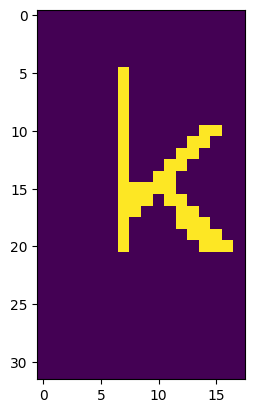

In [3]:
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt
# import gtn # Disabling because this does not run

simple_transforms = transforms.Compose([
  transforms.ToTensor(),
])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, len=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.len = len
    self.jitter = jitter
    self.noise = noise

  def __len__(self):
    return self.len

  def __iter__(self):
    for _ in range(self.len):
        text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text

  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    pos = (0, 5)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1

    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)


    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img = next(iter(sds))[0]
print(img.shape)
plt.imshow(img)

We can look at what the entire alphabet looks like in this dataset.

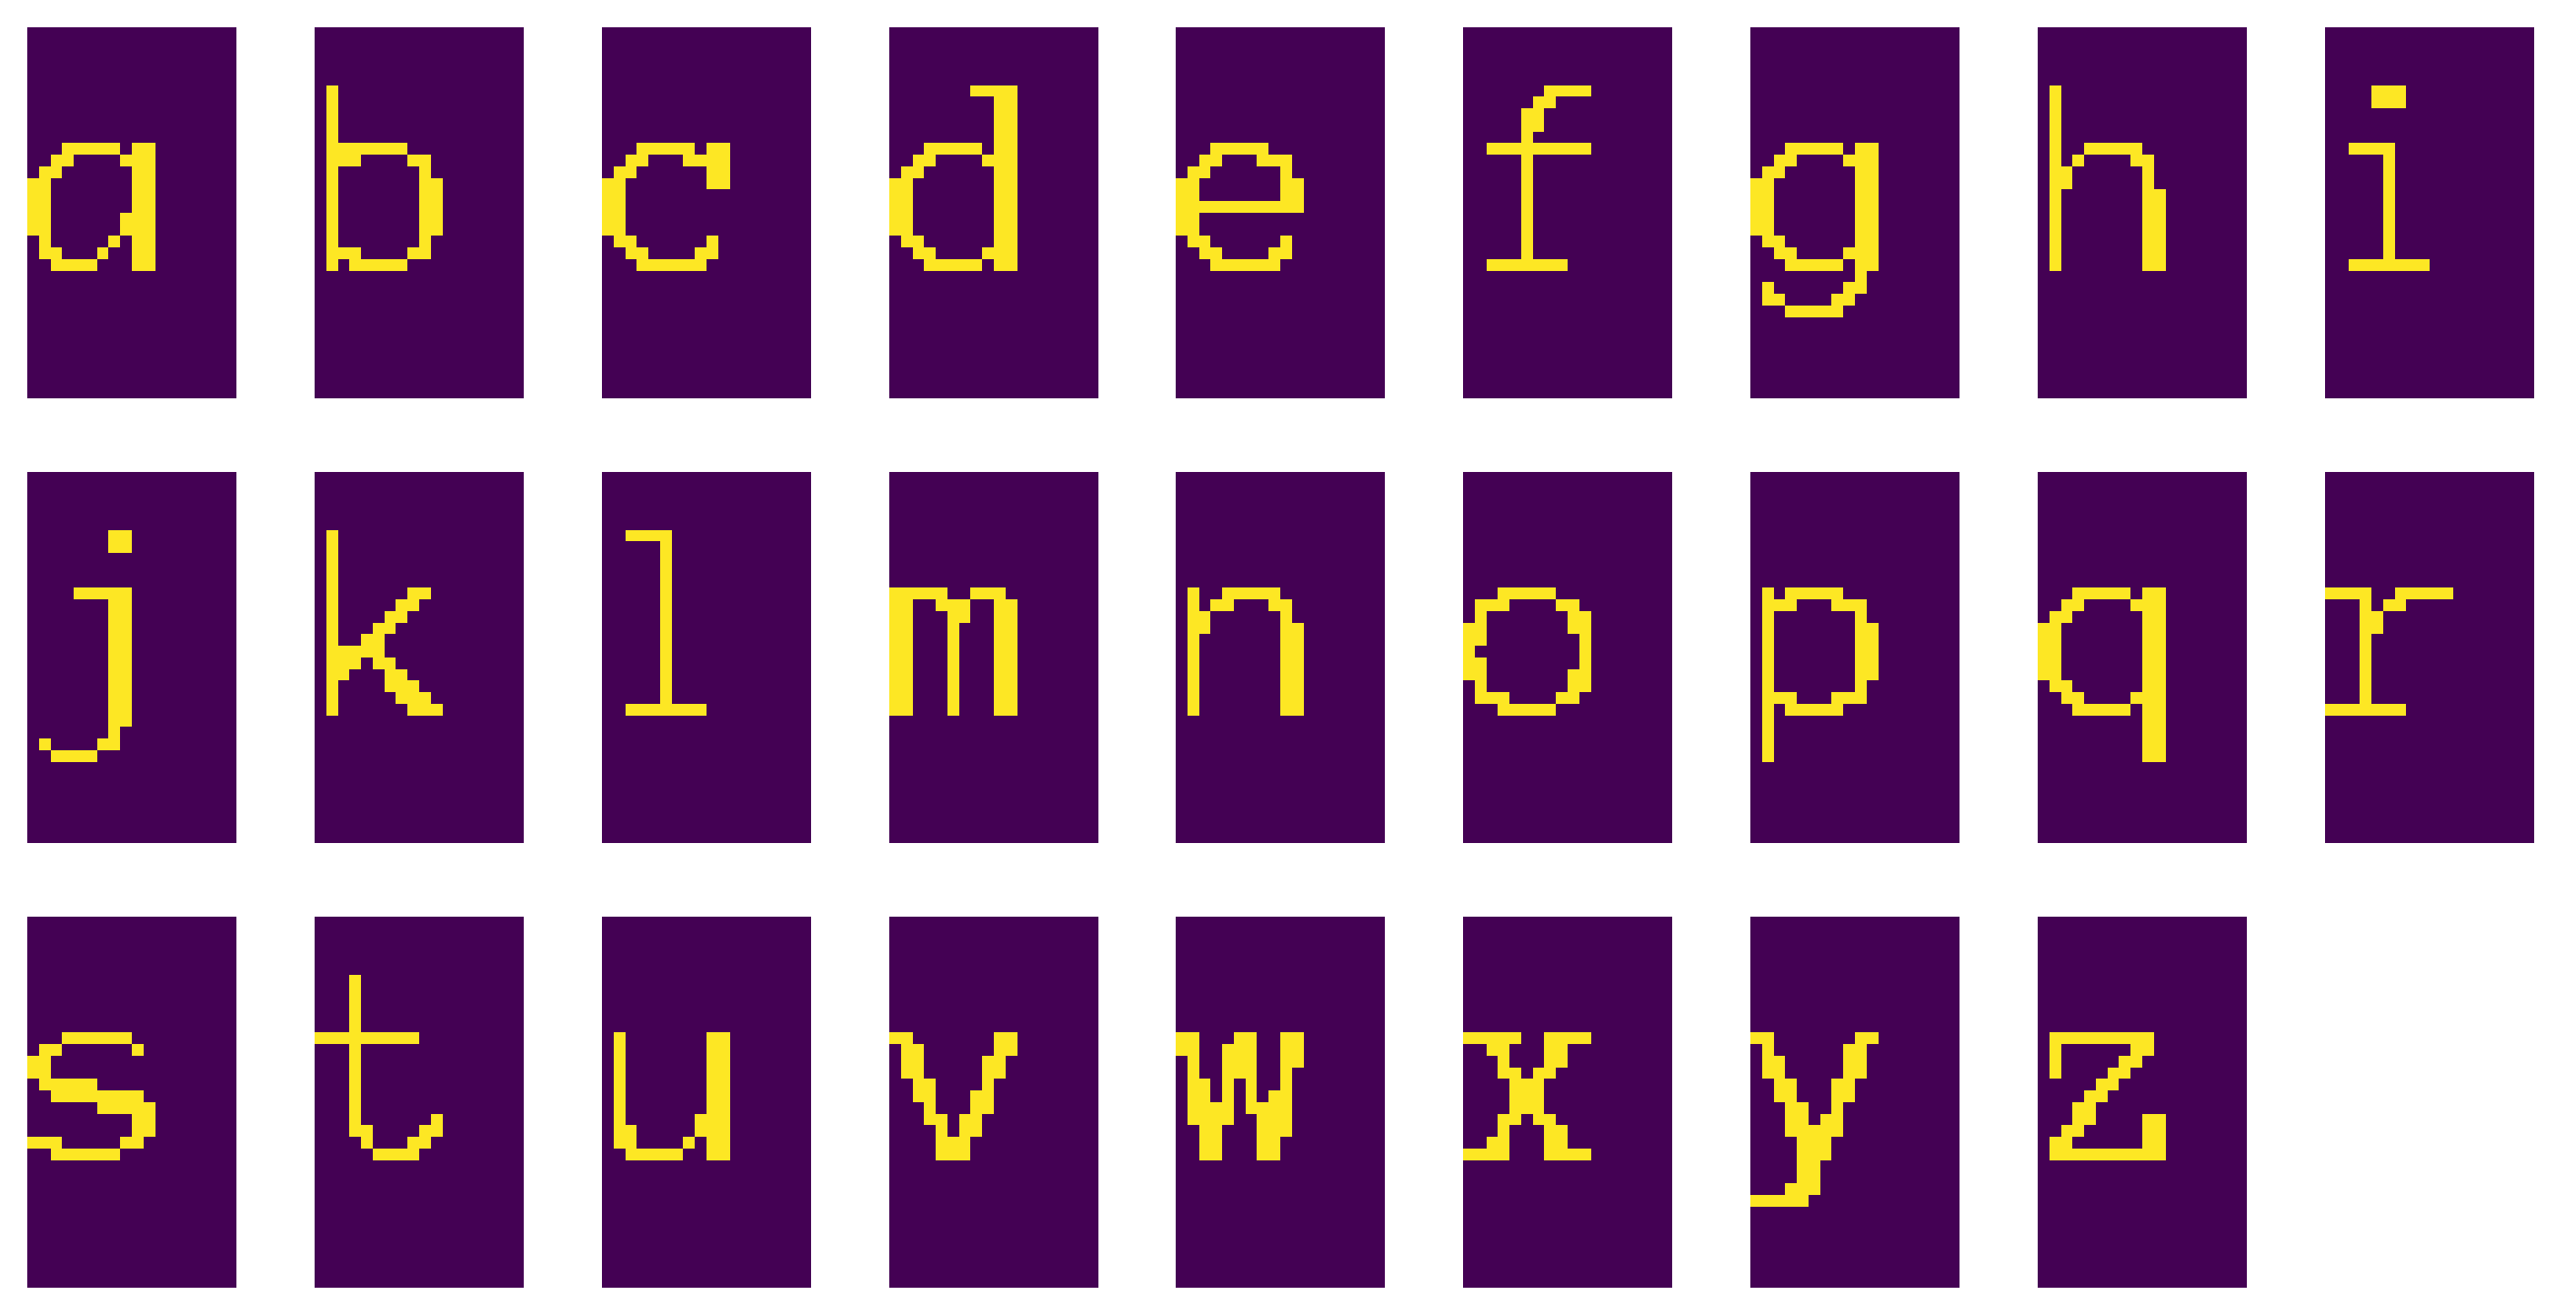

In [4]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=300)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')

plt.show()

We can also put the entire alphabet in one image.

(np.float64(-0.5), np.float64(339.5), np.float64(31.5), np.float64(-0.5))

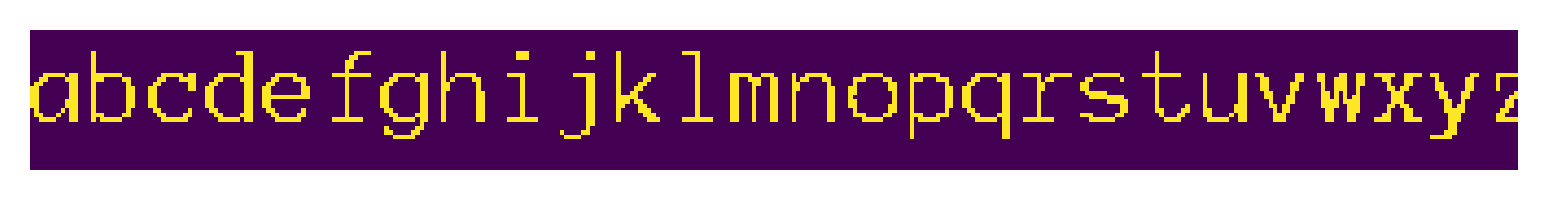

In [5]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=300)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things.
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [6]:
# Set a seed for deterministic behavior
torch.manual_seed(42)

In [7]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [8]:
from torch import nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional block: 1 -> 64 channels
        # Input spatial: 32 x W
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # -> 16 x W/2

        # Second convolutional block: 64 -> 256 channels
        # Input spatial: 16 x W/2
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # -> 8 x W/4

        # Final projection: 256 -> 27 channels (ALPHABET_SIZE)
        self.conv3 = nn.Conv2d(
            256,
            ALPHABET_SIZE,
            kernel_size=(8, 3),
            stride=(1, 1),
            padding=(0, 1)
        )

    def forward(self, x):
        # First conv block
        x = self.conv1(x)                    # (batch, 64, 32, W)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)                    # (batch, 64, 16, W/2)

        # Second conv block
        x = self.conv2(x)                    # (batch, 64, 16, W/2)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)                    # (batch, 256, 8, W/4)

        # Final projection to alphabet size
        x = self.conv3(x)                    # (batch, 27, 1, K)

        # Reshape
        x = x.squeeze(2)                     # Remove height: (batch, 27, K)
        x = x.permute(0, 2, 1)               # Rearrange: (batch, K, 27)

        return x  # (batch, K, 27)

Let's initalize the model and apply it to the alphabet image:

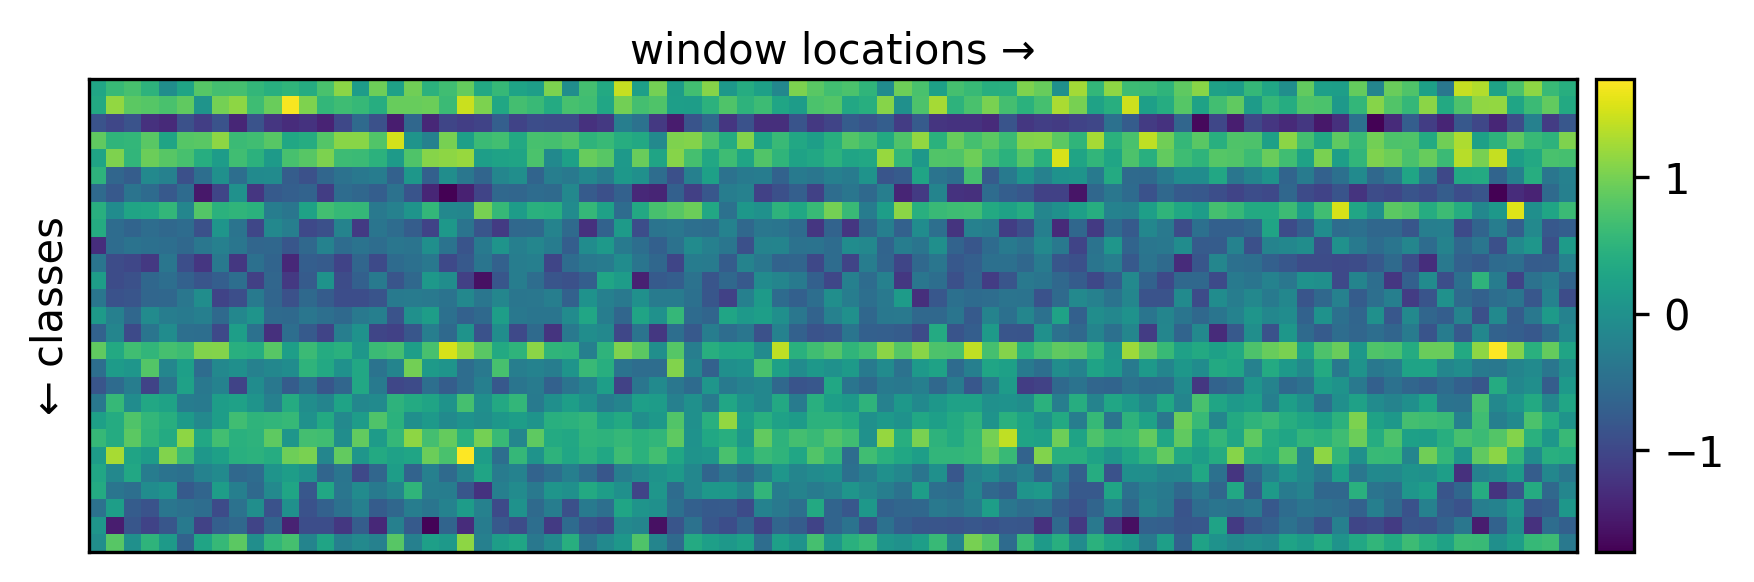

In [9]:
model = SimpleNet()
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))

def plot_energies(ce):
    fig=plt.figure(dpi=300)
    ax = plt.axes()
    im = ax.imshow(ce.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [10]:
def train_model(model, epochs, dataloader, criterion, optimizer, scheduler):
    model.train()
    progress_bar = tqdm(range(epochs))
    for epoch in progress_bar:
        total_epoch_loss = 0.0
        num_batches = 0
        for images, targets in dataloader:
            # Move to GPU if available
            images, targets = images.unsqueeze(1).cuda(), targets.cuda()

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images) # (batch, K, 27)
            outputs = outputs.mean(dim=1)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Step optimizer
            optimizer.step()

            # Update metrics
            total_epoch_loss += loss.item()
            num_batches += 1

        avg_epoch_loss = total_epoch_loss / num_batches
        progress_bar.set_postfix({'loss': avg_epoch_loss, 'lr': optimizer.param_groups[0]['lr']})
        print(f"epoch = {epoch+1} | train_loss = {avg_epoch_loss:.4f}")

        # Step scheduler
        scheduler.step()

In [11]:
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))

    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(1, len=1000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=16, num_workers=0, collate_fn=simple_collate_fn)

model.cuda()
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

train_model(
    model,
    epochs,
    dataloader,
    cross_entropy,
    optimizer,
    scheduler
)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1 | train_loss = 1.5806
epoch = 2 | train_loss = 0.0771
epoch = 3 | train_loss = 0.0004
epoch = 4 | train_loss = 0.0002
epoch = 5 | train_loss = 0.0001
epoch = 6 | train_loss = 0.0001
epoch = 7 | train_loss = 0.0001
epoch = 8 | train_loss = 0.0001
epoch = 9 | train_loss = 0.0001
epoch = 10 | train_loss = 0.0001


In [12]:
def get_accuracy(model, dataset):
    cnt = 0
    for i, l in dataset:
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)

tds = SimpleWordsDataset(1, len=100)
assert get_accuracy(model, tds) == 1.0, 'Your model doesn\'t achieve 100% accuracy for 1 character'

Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

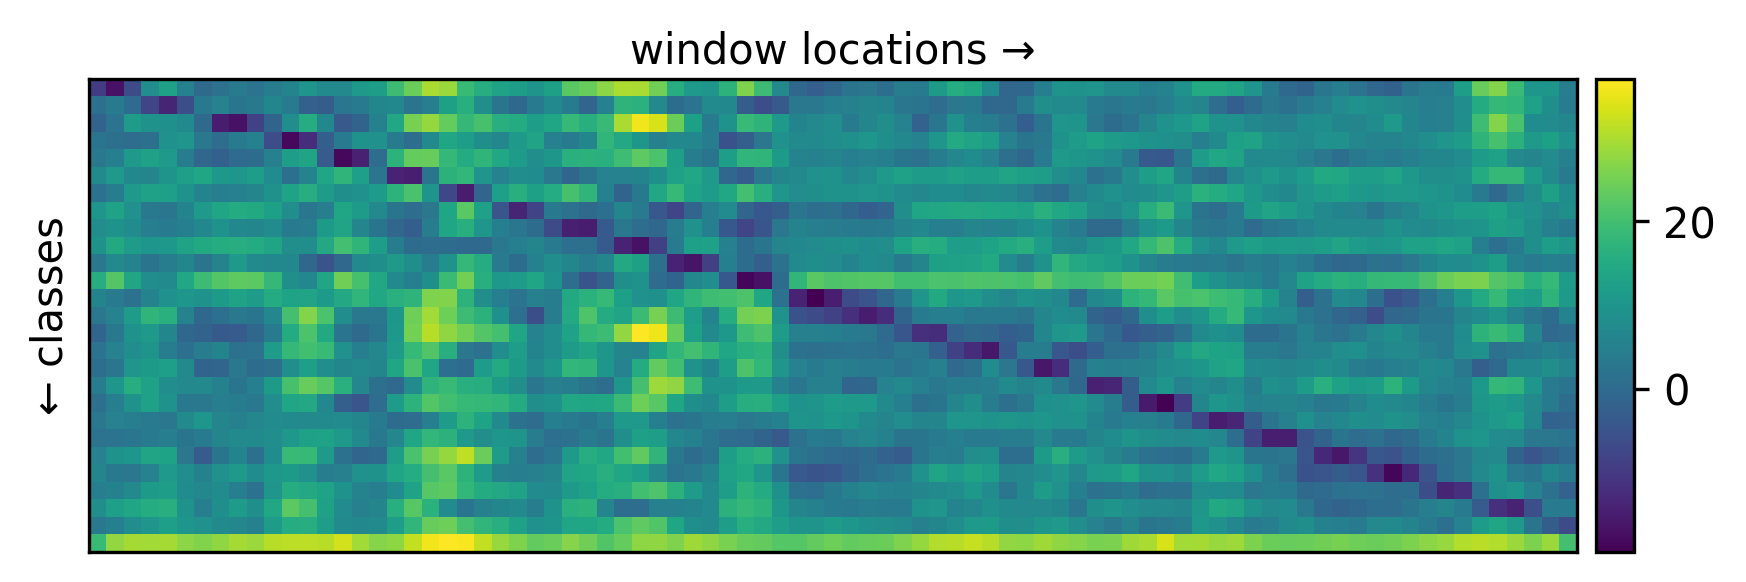

In [13]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())

Explain any classes that are lit up. What is still missing to be able to use it for transcription of words?

Answer: After training on single characters, the energy heatmap shows a clear diagonal pattern where the model has successfully learned to recognize individual letters:

1. **Diagonal dark regions (low energy)**: For each letter, we observe 2-3 consecutive window positions with low energy (dark color), though one cell is clearly the darkest. For example, for 'a' (row 0), the first 2-3 window positions show dark colors, with one being darkest. This pattern repeats for all letters - 'b' (row 1) has dark spots around positions 3-6, 'c' (row 2) around positions 7-10, and so on. This occurs because:
   - There are more window positions (K ≈ W/4 ≈ 85 windows for the alphabet image) than letters (26 letters)
   - Each letter occupies multiple pixels in width, so multiple overlapping windows can "see" the same character
   - The darkest cell in each group indicates the window position with the best centered view of that character

2. **Bright last row (high energy for separator)**: Row 26 (the separator/blank character '_') shows consistently high energy (bright color) across all window positions. This indicates that the model is strongly predicting that the separator is *not* present, which makes sense since the alphabet image contains only continuous letters without any spaces or separators.

3. **What is still missing**: While the model can recognize individual letters, it cannot yet transcribe complete words because:
   - It has never been trained on the separator character (index 27) appearing between letters
   - It doesn't know when to predict separators vs. characters in multi-character sequences
   - It lacks the ability to properly segment and align variable-length words
   - Training on multi-character words with proper alignment (using Viterbi) is needed to teach the model where separators should appear between characters, enabling it to distinguish sequences like 'aa' from 'a'.


## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [14]:
def build_path_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix of shape BATCH_SIZE x L x T
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    batch_size, L, _ = energies.shape
    T = targets.shape[1]
    # Move targets to the same device as energies
    targets = targets.to(energies.device)
    # Expand targets to match energies dimensions
    # targets: (batch_size, T) -> (batch_size, L, T)
    targets_expanded = targets.unsqueeze(1).expand(batch_size, L, T)
    # We need to gather from target indices -> energies[i, j, targets[i, k]] for all i, j, k
    path_matrix = torch.gather(energies, 2, targets_expanded)
    return path_matrix

def build_ce_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \ververtt = targets.unsqueeze(1).repeat(1,energies.shape[1],1)t l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    batch_size, L, num_classes = energies.shape
    T = targets.shape[1]
    # Expand energies: (batch_size, L, 27) -> (batch_size, L, T, 27)
    energies_expanded = energies.unsqueeze(2).expand(batch_size, L, T, num_classes)
    # Expand targets: (batch_size, T) -> (batch_size, L, T)
    targets_expanded = targets.unsqueeze(1).expand(batch_size, L, T)
    # Reshape for cross_entropy computation
    # cross_entropy expects (N, C) for input and (N,) for target
    energies_flat = energies_expanded.reshape(-1, num_classes)  # (batch_size*L*T, 27)
    targets_flat = targets_expanded.reshape(-1)  # (batch_size*L*T,)
    # Compute cross entropy
    ce_flat = cross_entropy(energies_flat, targets_flat, reduction='none')
    # Reshape back to (batch_size, L, T)
    ce_matrix = ce_flat.reshape(batch_size, L, T)
    return ce_matrix

Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '\_' models the separation between words, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc).
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [15]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    result = list()
    for char in s:
        # Add the character (mapped to 0-25)
        result.append(ord(char) - ord('a'))
        # Add the separator (mapped to 26)
        result.append(26)
    return torch.tensor(result, dtype=torch.long)

Now, let's plot energy table built on our model's prediction for alphabet image.

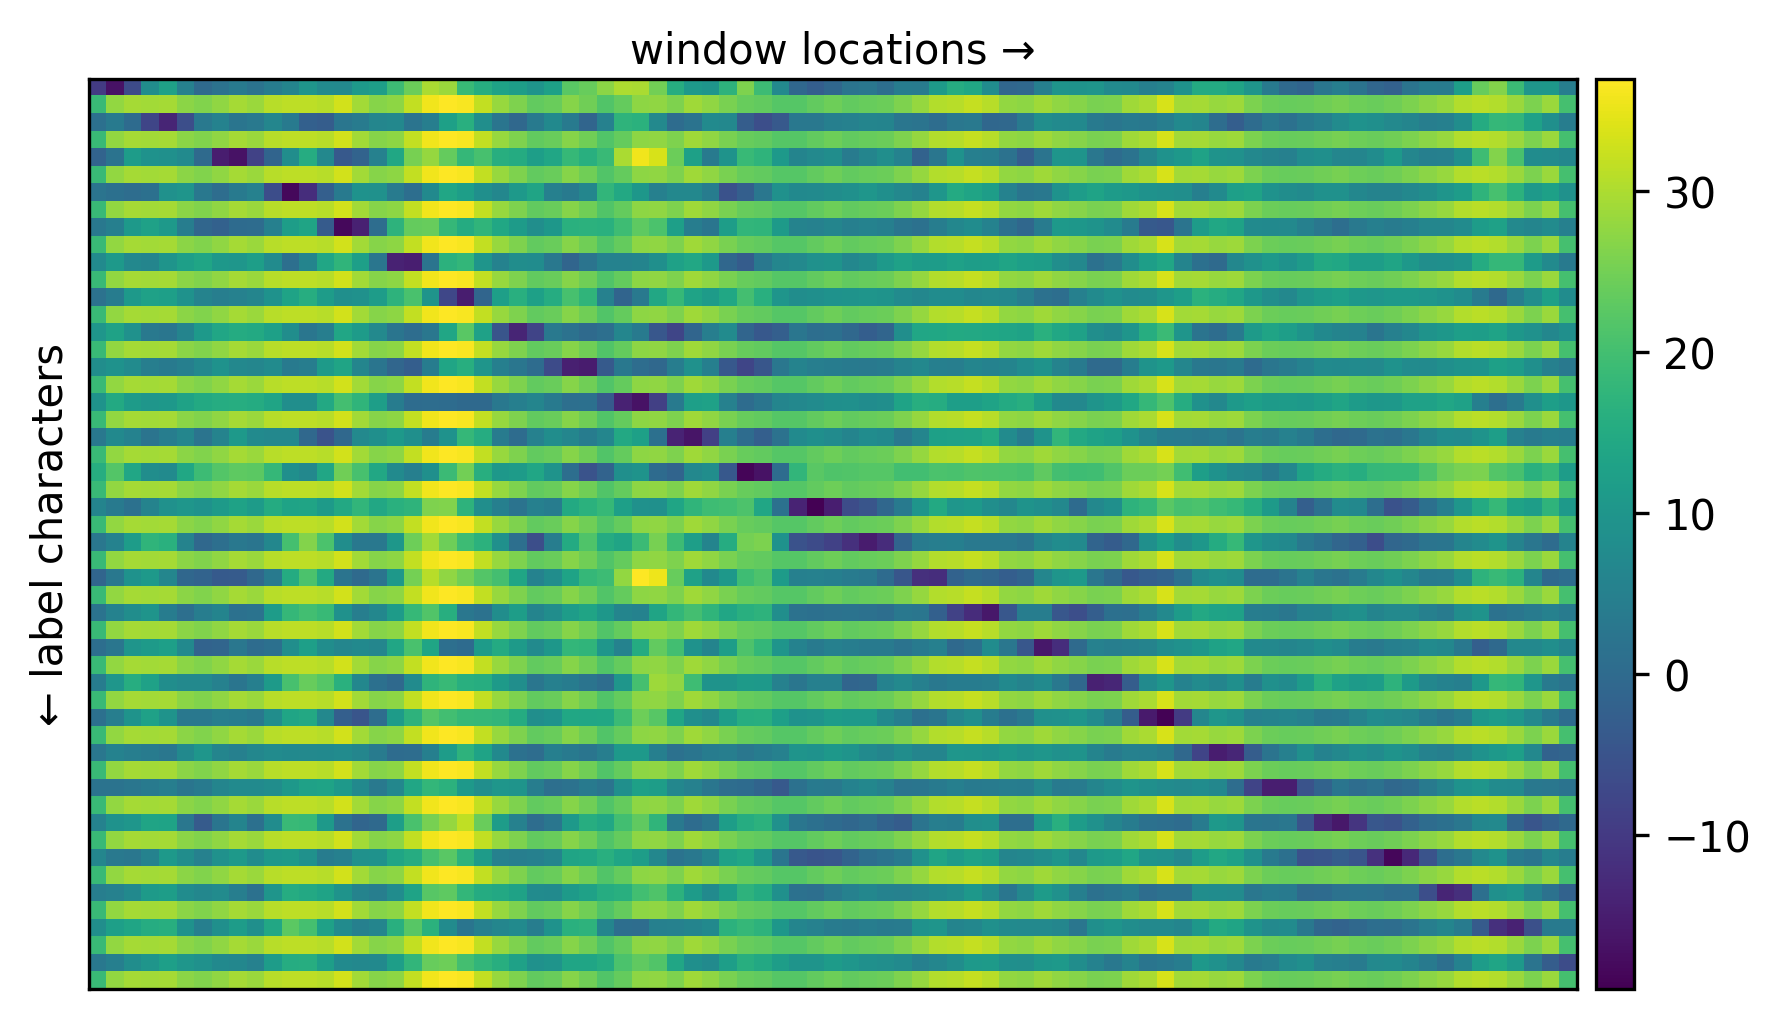

In [16]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=300)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

energies = model(alphabet.cuda().view(1, 1, *alphabet.shape))
targets = transform_word(string.ascii_lowercase).unsqueeze(0)

pm = build_path_matrix(energies, targets)
plot_pm(pm[0].detach())

What do you see? What does the model classify correctly, and what does it have problems with?

Answer: The path matrix shows how well the model's predictions align with the transformed target sequence 'a_b_c_..._z_' (where _ is the separator at index 27):

**What the model classifies correctly:**
- Individual letter positions: For each actual letter in the target (rows 0, 2, 4, ... corresponding to 'a', 'b', 'c', ...), we see the same pattern as before: few dark cells (low energy) at the appropriate window positions, with one being darkest, indicating the model correctly identifies these letters. For 'a' (row 0), windows 0-2 are dark; for 'b' (row 2), windows 3-6 are dark, and so on. This shows the model correctly identifies these letters at their corresponding positions.

**What the model has problems with:**
- Separator positions: After each letter row, there's a row with extremely bright values (very high energy) across all window positions, showing almost no confidence anywhere. These bright rows correspond to the separator character '_' (appearing at odd target indices: 1, 3, 5, ... in the transformed target 'a_b_c_..._z_').
- The alternating pattern (letter row with 2-3 dark cells, separator row with all bright cells, letter row with 2-3 dark cells, ...) reveals that while the model learned to recognize letters during single-character training, it never learned when or where separators should appear.
- The model essentially has no training examples of the separator character, so it assigns very high energy (low confidence) to separator predictions at all positions.

**Conclusion:** The model needs training on multi-character sequences to learn that separators appear between letters, not within them. This will allow proper segmentation and the ability to distinguish 'aa' from 'a'.

Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. Where does the trajectory start, and where does it end? What other properties does the trajectory have? Can you see where an optimal trajecotry would be passing through in the plot above?

Answer: The optimal trajectory through the path matrix `pm` represents the best alignment between the model's window predictions and the target sequence:

**Where it starts and ends:**
- The trajectory must start at position (0, 0) - the top-left corner (first window position, first target character 'a')
- The trajectory must end at position (L-1, T-1) - the bottom-right corner (last window position, last target character '_' after 'z')

**Properties of the trajectory:**
- **Non-decreasing**: The trajectory can only move right (→) or diagonally down-right (↘), never backward. In terms of target indices j, we must have z[i] ≤ z[i+1].
- **No skipping**: The trajectory cannot skip target characters - it must visit every target index at least once. It can advance by at most 1 target index per step: z[i+1] ≤ z[i] + 1.
- **Continuous coverage**: Every target character must be "covered" by at least one window position along the path.

**Where the optimal trajectory passes:**
Looking at the plot above, the optimal trajectory would:
- Follow the dark (low energy) cells through the letter rows (0, 2, 4, ...) where the model is confident
- Navigate through or around the bright (high energy) separator rows (1, 3, 5, ...) where the model has low confidence
- The path would create a roughly diagonal pattern from (0,0) to (L-1, T-1), staying in low-energy regions when possible
- The trajectory minimizes the total sum of energies along its path, choosing the darkest available cells while respecting the movement constraints

Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [17]:
def path_energy(pm, path):
    # inputs:
    #   pm - a matrix of energies
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    L = len(path)
    T = pm.shape[1]

    # Check validity constraints from C(z):
    # 1. Path must start at 0: z(0) = 0
    if path[0] != 0:
        return torch.tensor(2**30)

    # 2. Path must end at T-1: z(L-1) = T-1
    if path[-1] != T - 1:
        return torch.tensor(2**30)

    # 3. Path must be non-decreasing and not skip more than 1: z(i) <= z(i+1) <= z(i) + 1
    for i in range(L - 1):
        if path[i] > path[i + 1]:  # Non-decreasing
            return torch.tensor(2**30)
        if path[i + 1] > path[i] + 1:  # Can't skip more than 1
            return torch.tensor(2**30)

    # If valid, compute sum of energies along the path
    indices = torch.arange(L)
    path_tensor = torch.tensor(path) if not isinstance(path, torch.Tensor) else path
    energy = pm[indices, path_tensor].sum()

    return energy

Now we can check some randomly generated paths and see the associated energies for our alphabet image:

energy is 1377.4705810546875


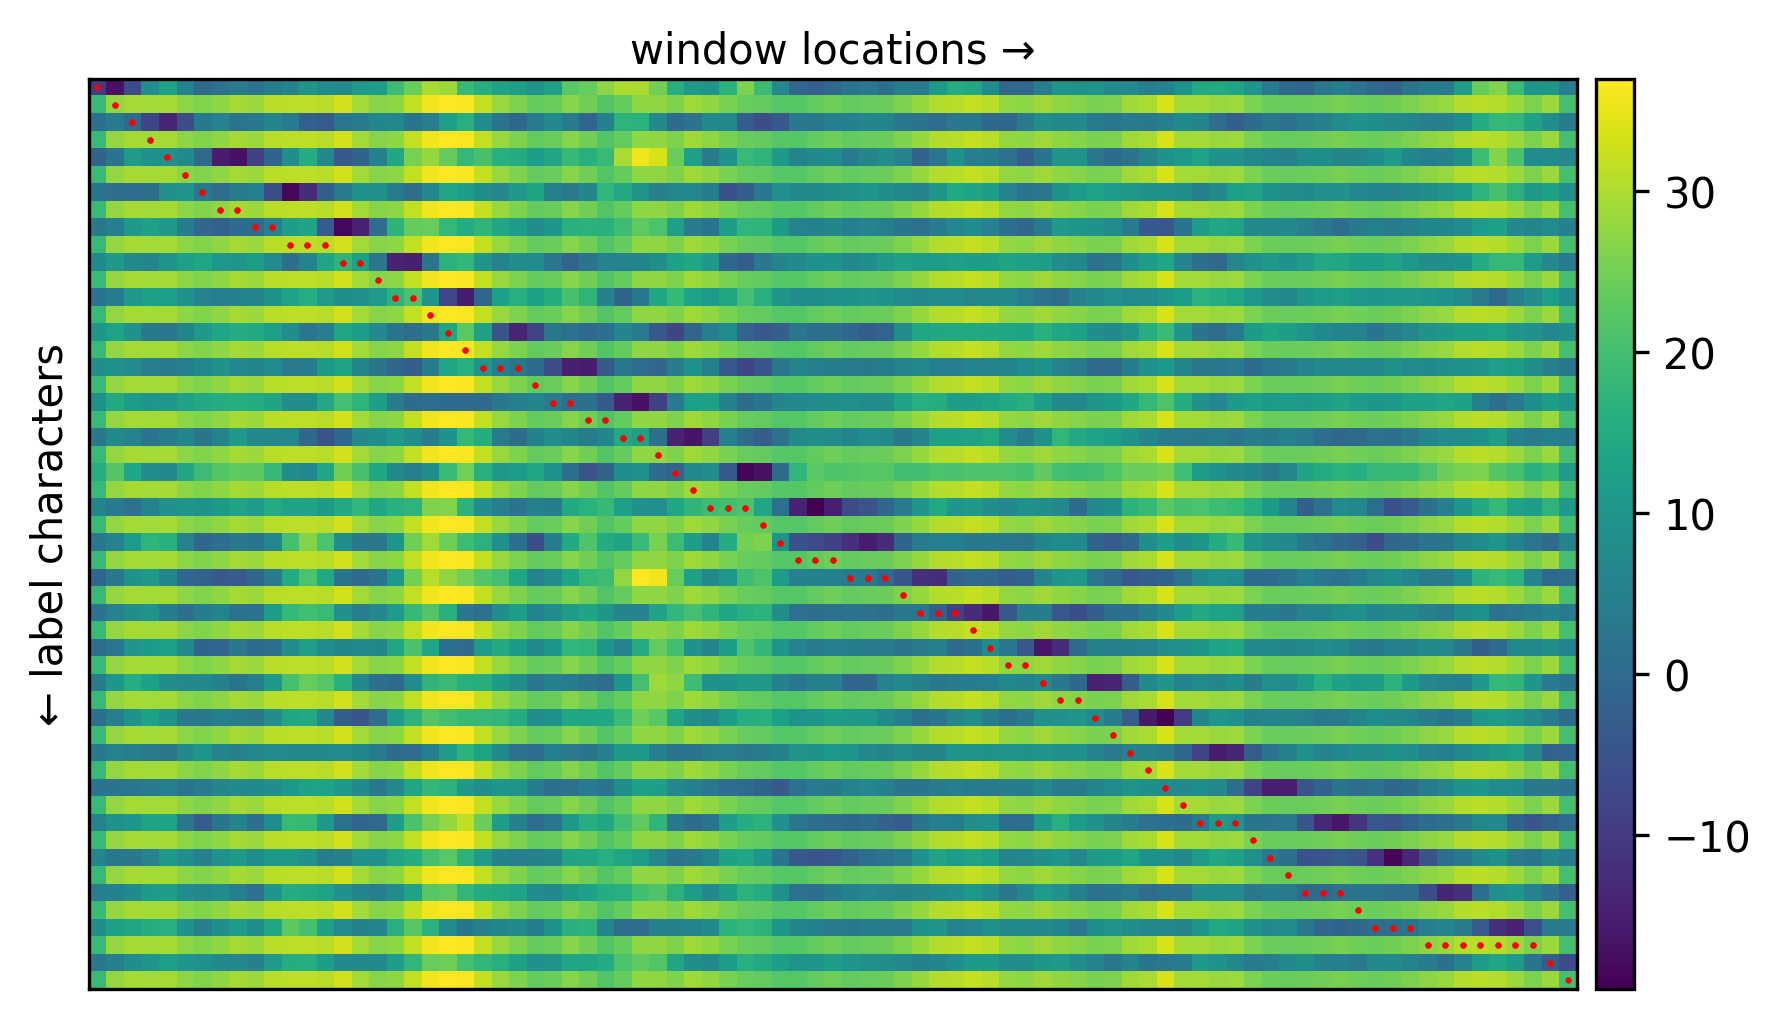

In [18]:
path = torch.zeros(energies.shape[1] - 1)
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path).item())

Now, generate two paths with bad energies, print their energies and plot them.

Bad Path 1 (skipping characters) energy: 1073741824
Bad Path 2 (non-monotonic) energy: 1073741824


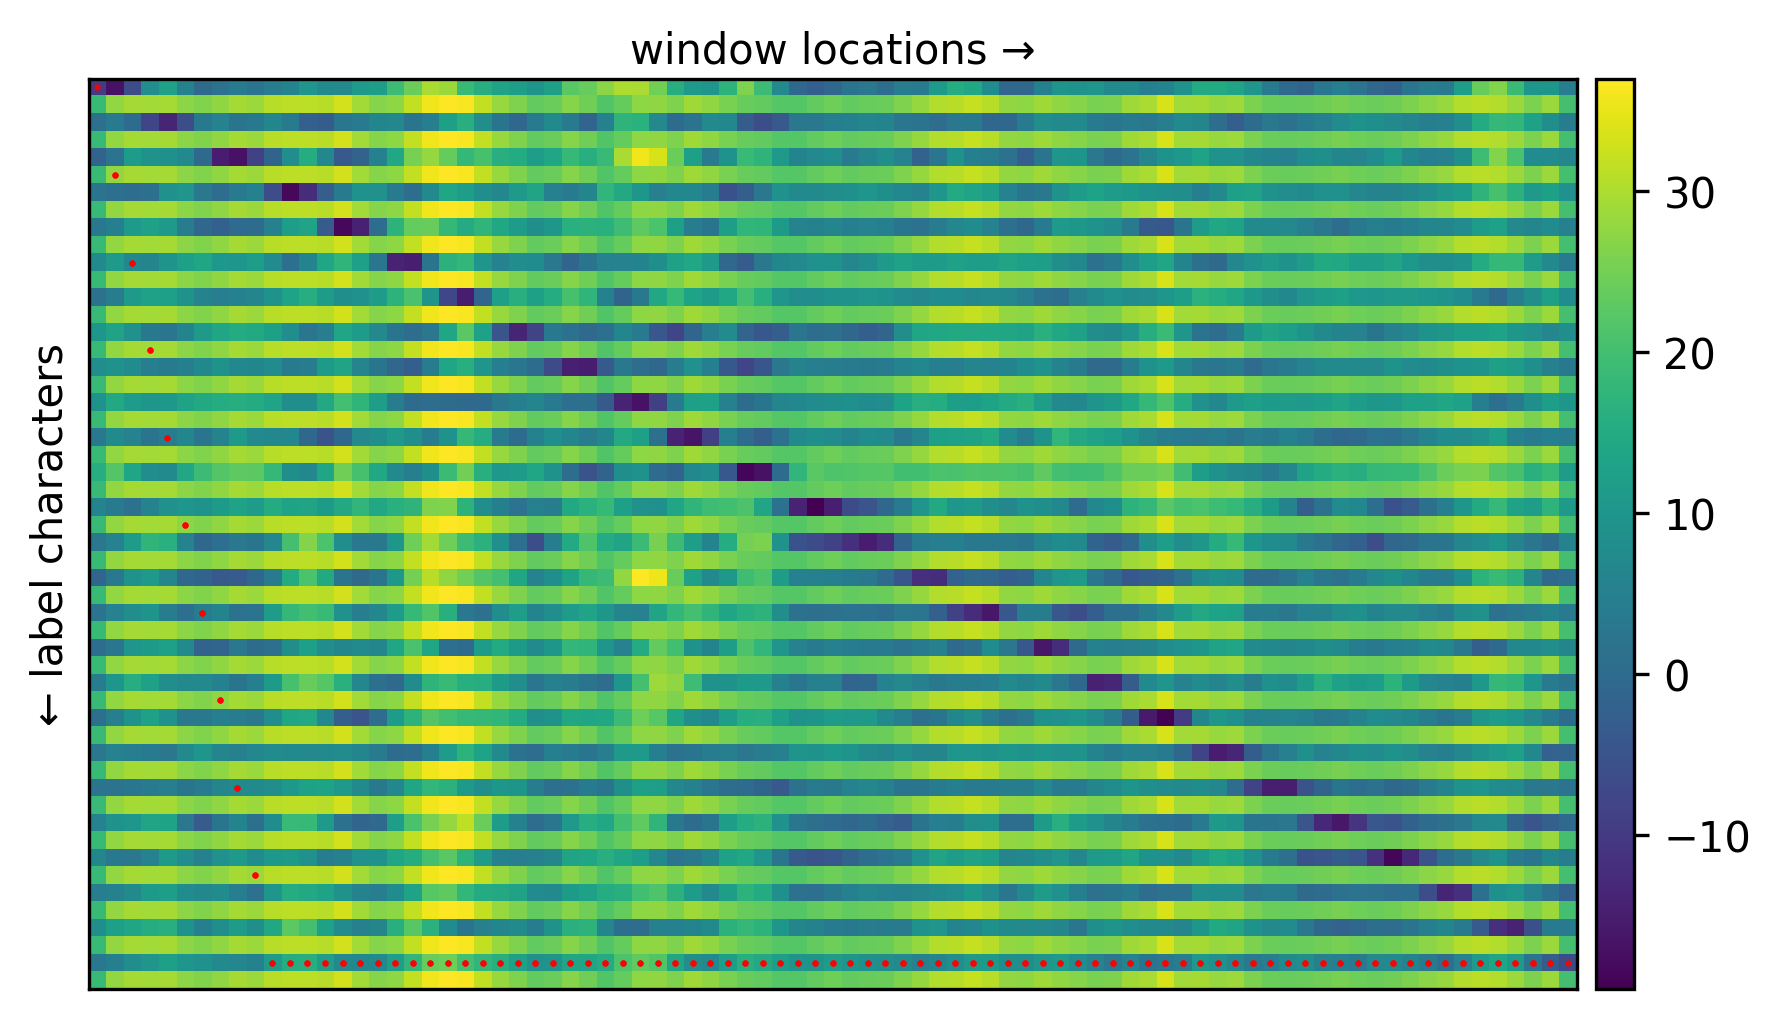

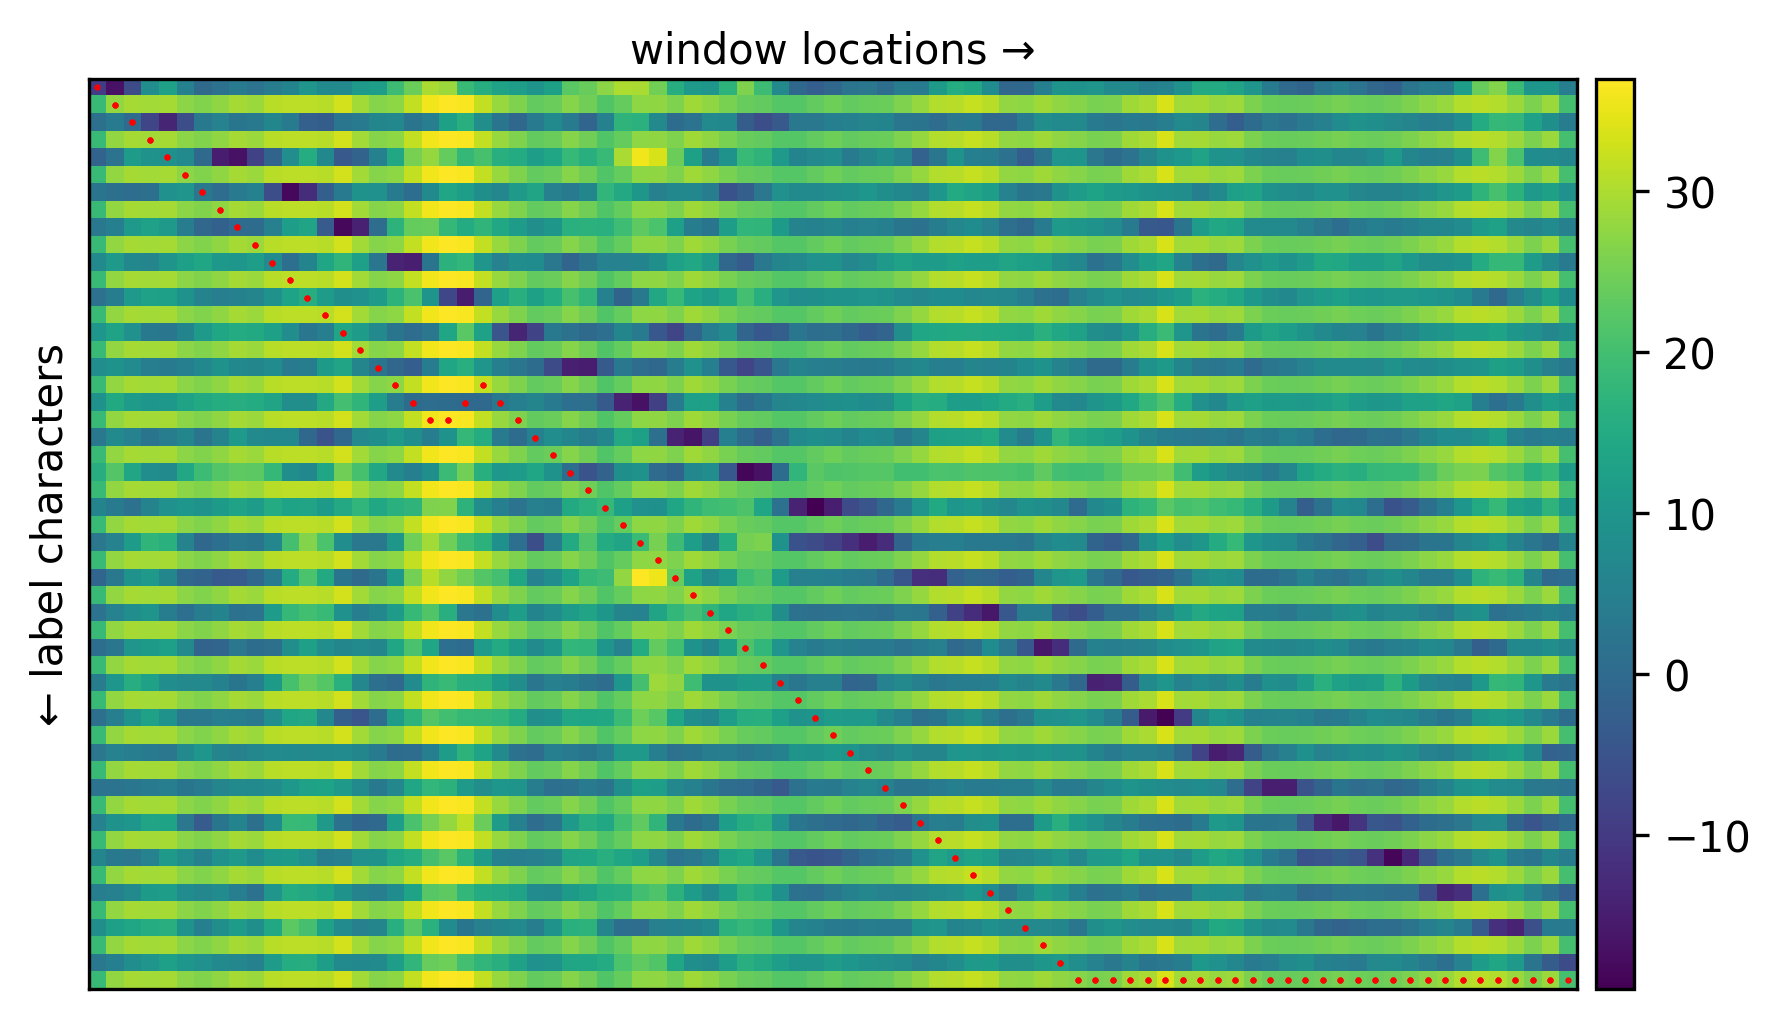

In [19]:
# Bad Path 1: Skip characters (violates z(i+1) <= z(i) + 1)
# Jump from target index 0 to 5, skipping indices in between
path1 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# Pad to match energies length
while len(path1) < energies.shape[1]:
    path1.append(path1[-1])
path1 = path1[:energies.shape[1]]

points1 = list(zip(range(len(path1)), path1))
plot_pm(pm[0].detach(), points1)
energy1 = path_energy(pm[0], path1)
print(f'Bad Path 1 (skipping characters) energy: {energy1.item()}')

# Bad Path 2: Non-monotonic path (violates z(i) <= z(i+1))
# Go backwards at some point
path2 = list(range(20)) + [19, 18] + list(range(17, targets.shape[1]))
# Adjust length to match energies
path2 = path2[:energies.shape[1]]
if len(path2) < energies.shape[1]:
    path2 += [targets.shape[1] - 1] * (energies.shape[1] - len(path2))

points2 = list(zip(range(len(path2)), path2))
plot_pm(pm[0].detach(), points2)
energy2 = path_energy(pm[0], path2)
print(f'Bad Path 2 (non-monotonic) energy: {energy2.item()}')

## Part - 1\: Viterbi

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

Below, you'll need to implement this algorithm:

In [20]:
def find_path(pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path,
    #         2. list of tuples - points of the best path in the pm matrix
    #         3. the dp array
    L, T = pm.shape
    # Initialize dp array with infinity
    dp = torch.full((L, T), float('inf'), device=pm.device)

    # backpointer[i, j] stores which previous cell we came from
    backpointer = torch.zeros((L, T, 2), dtype=torch.long, device=pm.device)

    # Base case: dp[0, 0] = pm[0, 0]
    dp[0, 0] = pm[0, 0]

    # Fill the dp table
    for i in range(1, L):
        for j in range(T):
            # We can come from dp[i-1, j] (stay at same target index)
            if dp[i-1, j] < float('inf'):
                if dp[i-1, j] + pm[i, j] < dp[i, j]:
                    dp[i, j] = dp[i-1, j] + pm[i, j]
                    backpointer[i, j] = torch.tensor([i-1, j])

            # We can come from dp[i-1, j-1] (advance to next target index)
            if j > 0 and dp[i-1, j-1] < float('inf'):
                if dp[i-1, j-1] + pm[i, j] < dp[i, j]:
                    dp[i, j] = dp[i-1, j-1] + pm[i, j]
                    backpointer[i, j] = torch.tensor([i-1, j-1])

    # The best path ends at dp[L-1, T-1]
    free_energy = dp[L-1, T-1]

    # Backtrack to reconstruct the path
    path = []
    i, j = L-1, T-1

    while i > 0 or j > 0:
        path.append((i, j))
        prev_i, prev_j = backpointer[i, j].tolist()
        i, j = prev_i, prev_j

    path.append((0, 0))  # Add starting point
    path.reverse()  # Reverse to get path from start to end

    return free_energy, path, dp

Let's take a look at the best path:

free energy is -82.08771514892578


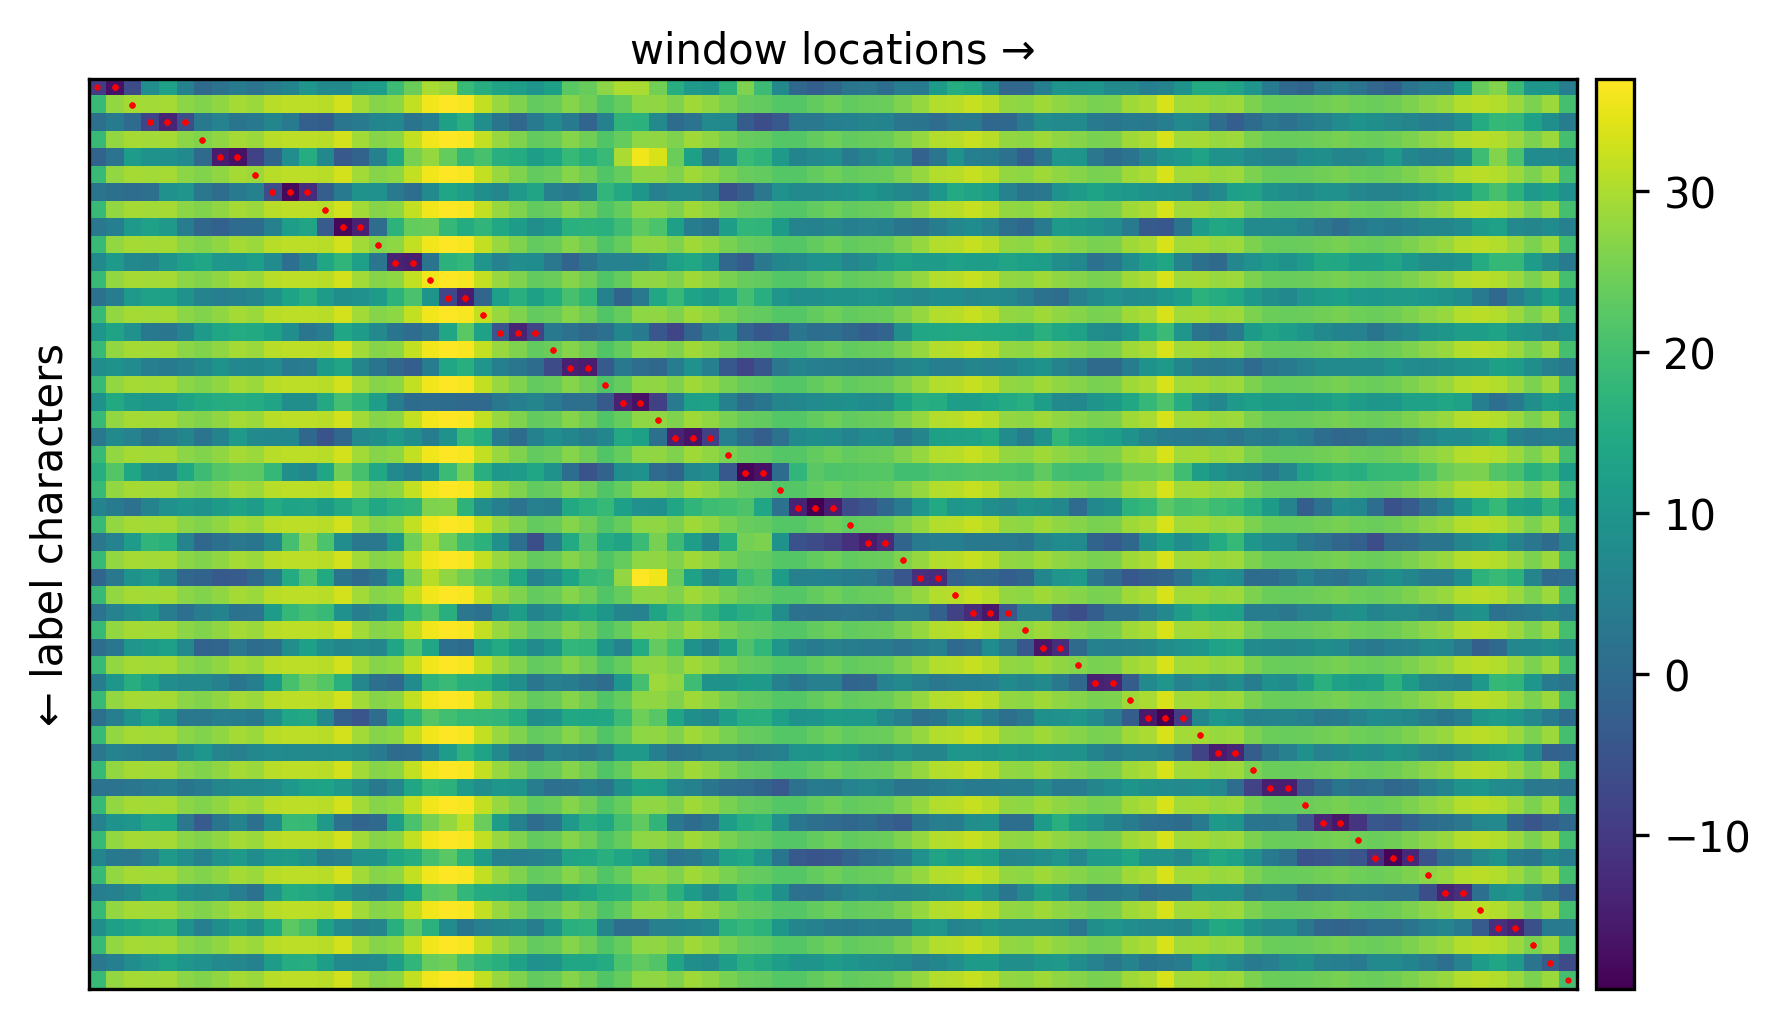

In [21]:
free_energy, path, d = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

We can also visualize the dp array. You may need to tune clamping to see what it looks like.

(np.float64(-0.5), np.float64(84.5), np.float64(51.5), np.float64(-0.5))

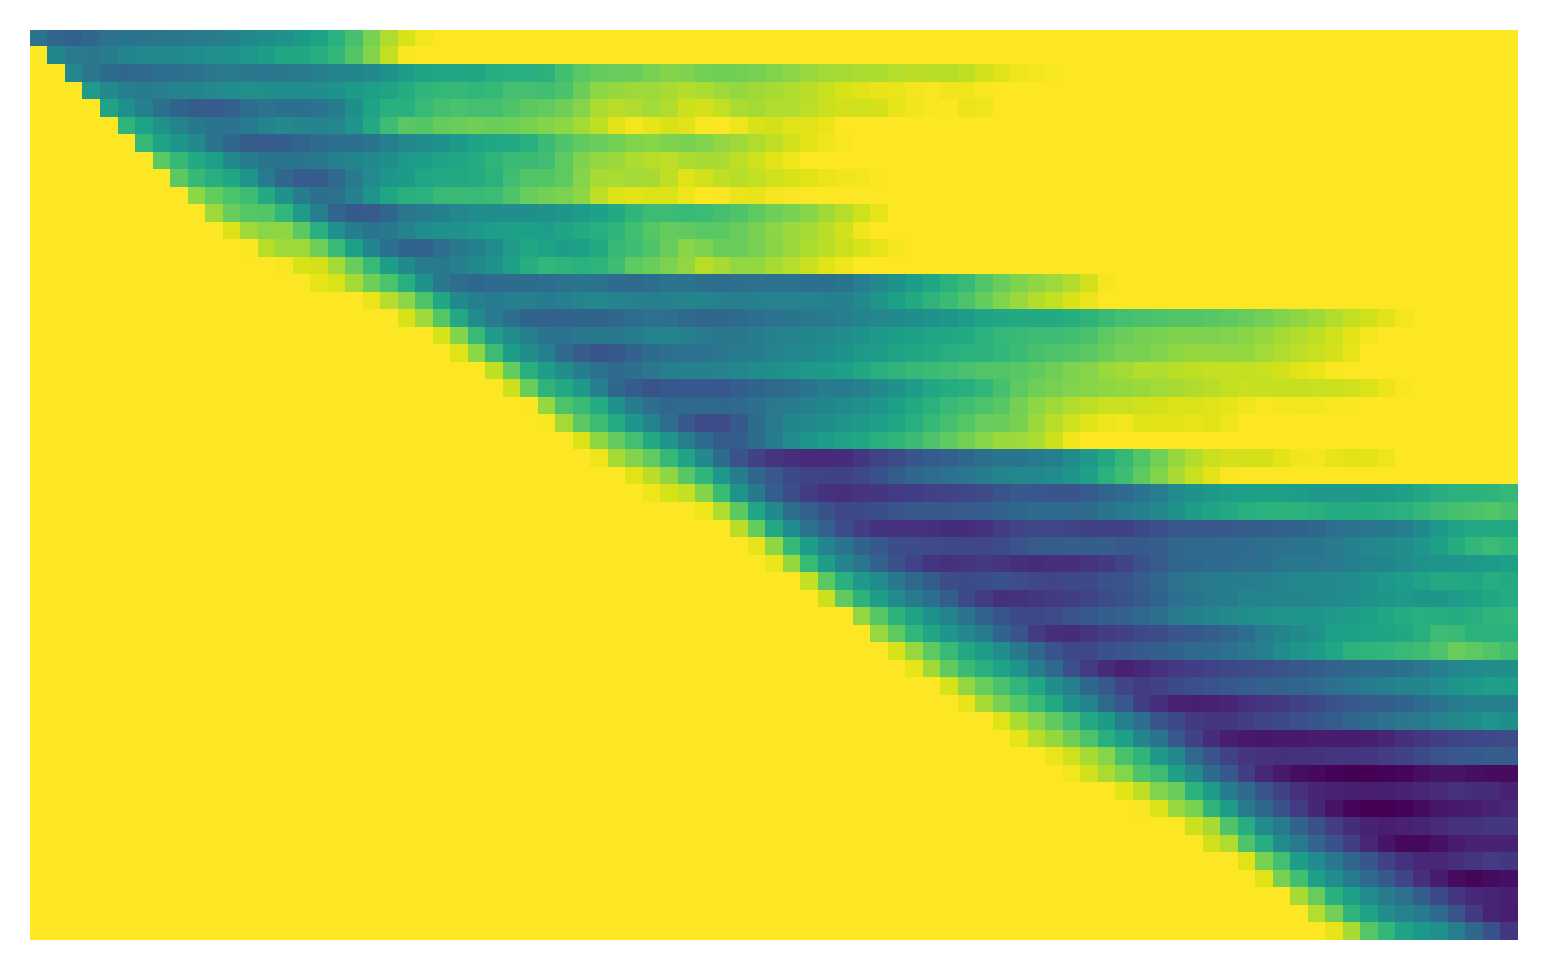

In [22]:
plt.figure(dpi=300)
plt.imshow(d.cpu().detach().T.clamp(torch.min(d).item(), 200))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [23]:
def train_ebm_model(model, num_epochs, train_loader, criterion, optimizer, scheduler):
    ''' Train EBM Model using find_path()'''
    pbar = tqdm(range(num_epochs))
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    model.train()
    for epoch in pbar:
        start_time = time.time()
        total_epoch_loss = 0.0

        for images, targets in train_loader:
            # Move to GPU
            images, targets = images.unsqueeze(1).cuda(), targets.cuda()
            batch_size = images.shape[0]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            energies = model(images)  # Shape: (batch_size, L, 27)

            # Process each sample in the batch
            total_batch_loss = 0.0
            for b in range(batch_size):
                # Get energy matrix for this sample
                sample_energies = energies[b:b+1]  # (1, L, 27)
                sample_targets = targets[b:b+1]    # (1, T)

                # Build path matrix (energies indexed by targets)
                pm = build_path_matrix(sample_energies, sample_targets)  # (1, L, T)

                # Find best path using Viterbi
                free_energy, path, dp = find_path(pm[0])

                # Build cross-entropy matrix
                ce_matrix = build_ce_matrix(sample_energies, sample_targets)  # (1, L, T)

                # Calculate loss as sum of cross-entropies along the best path
                # path is list of tuples (i, j)
                sample_loss = 0.0
                for i, j in path:
                    sample_loss += ce_matrix[0, i, j]

                total_batch_loss += sample_loss

            # Average loss over batch
            avg_batch_loss = total_batch_loss / batch_size

            # Backward pass
            avg_batch_loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Step optimizer
            optimizer.step()

            # Update metrics
            total_epoch_loss += avg_batch_loss.item()

        # Step scheduler
        scheduler.step()

        total_train_loss = total_epoch_loss
        epoch_time = time.time() - start_time
        print(f"epoch = {epoch+1} | train_loss = {total_train_loss:.4f}")
        pbar.set_postfix({'train_loss': total_train_loss / len(sds), 'Epoch Time': epoch_time})

    return

In [24]:
import copy
import time

def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

ebm_model = copy.deepcopy(model)
ebm_model.cuda()
epochs = 10
optimizer = torch.optim.AdamW(ebm_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation.
# This is not ideal, as for loops are very slow, but for
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.
# also: remember that the loss is the sum of cross_entropies along the path, not
# energies!

train_ebm_model(
    ebm_model,
    epochs,
    dataloader,
    cross_entropy,
    optimizer,
    scheduler
)


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1 | train_loss = 164.5367
epoch = 2 | train_loss = 0.4070
epoch = 3 | train_loss = 0.0025
epoch = 4 | train_loss = 0.0017
epoch = 5 | train_loss = 0.0013
epoch = 6 | train_loss = 0.0010
epoch = 7 | train_loss = 0.0010
epoch = 8 | train_loss = 0.0009
epoch = 9 | train_loss = 0.0009
epoch = 10 | train_loss = 0.0008


Let's check what the energy matrix looks like for the alphabet image now.

free energy is -752.982421875


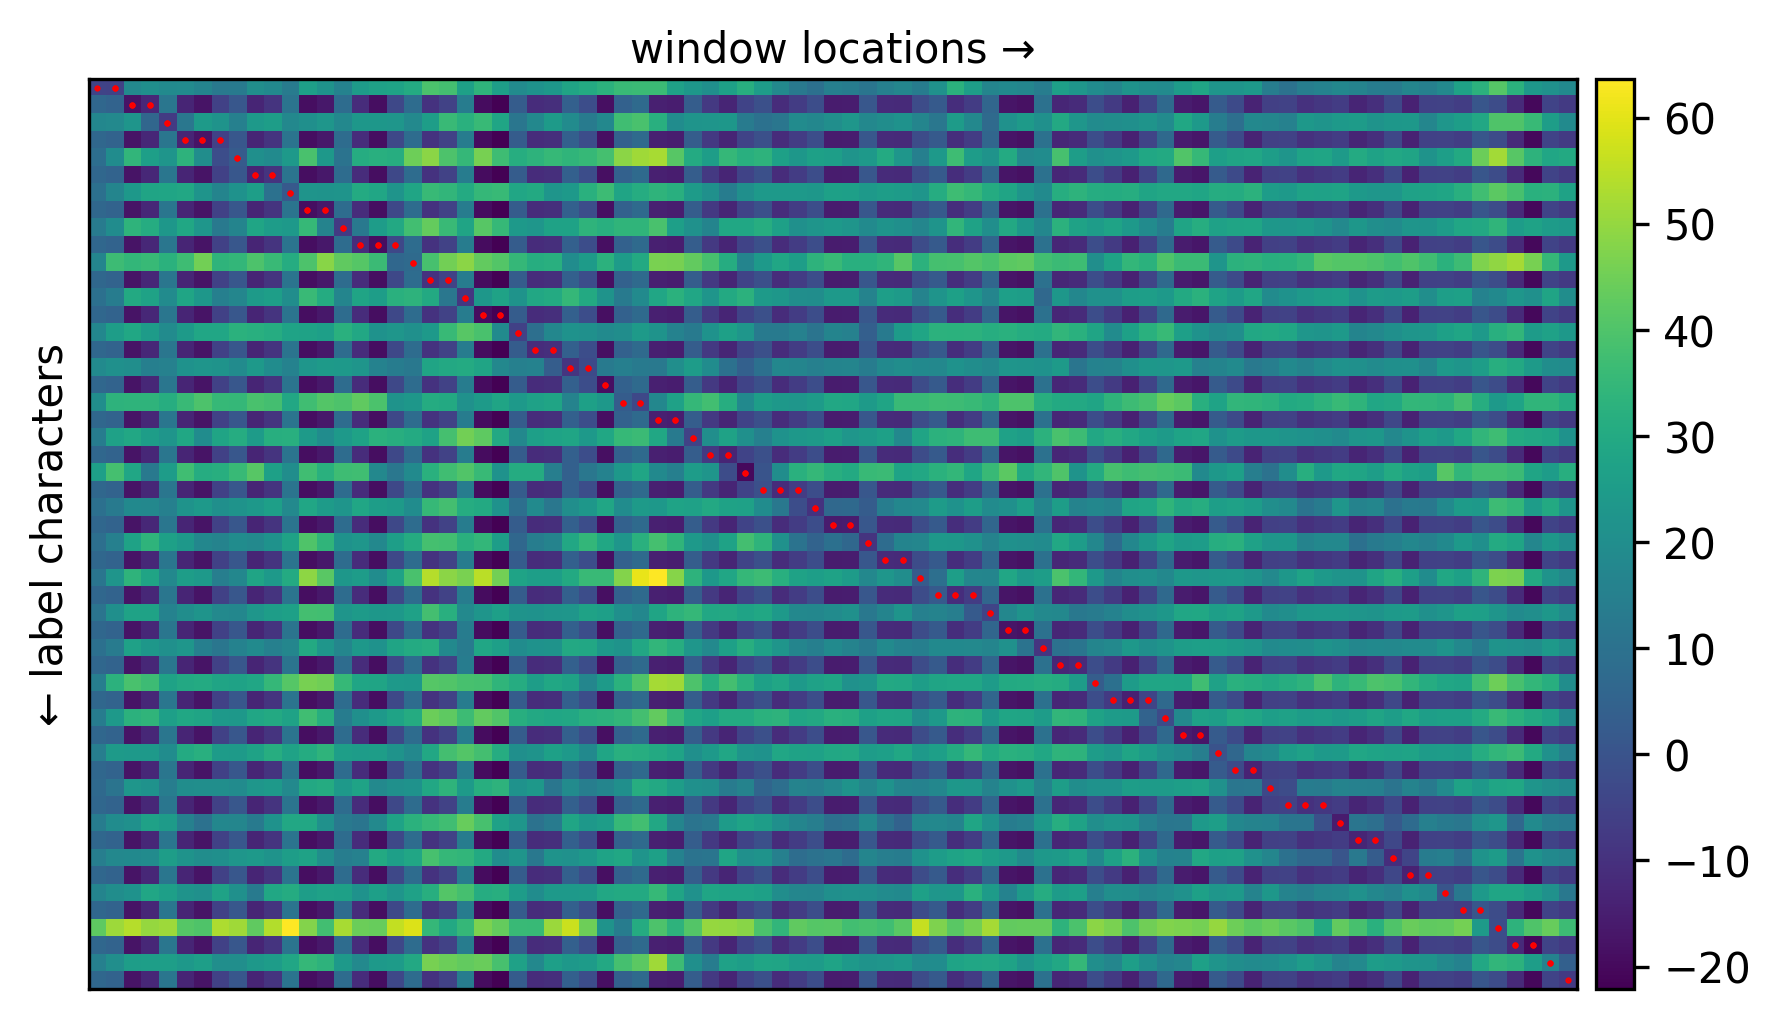

In [25]:
energies = ebm_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase)
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

Explain how the free energy changed, and why.

Answer: After training on multi-character sequences using the Viterbi alignment, the free energy has decreased significantly compared to before training. This is because:

**How the free energy changed:**
- Before multi-character training: The free energy was relatively high because the model assigned high energies (low confidence) to all separator positions (the bright rows in the path matrix).
- After Viterbi-based training: The free energy is now much lower, indicating the model has learned better predictions along the optimal alignment path.

**Why the change occurred:**
1. **Learned separator placement**: The model now understands when and where to predict the separator character (row index 26). The previously bright separator rows now show darker regions at appropriate positions, indicating the model has learned that separators appear between letters.

2. **Training on optimal alignments**: During each training iteration, the Viterbi algorithm found the best path (lowest energy alignment) between model predictions and target sequences. The loss function then reduced the cross-entropy along these optimal paths, teaching the model to:
   - Assign low energy to correct characters at their aligned positions
   - Assign low energy to separators between character groups
   - Better handle the spatial correspondence between window positions and character sequences

3. **Multi-character context**: By training on 2-character words, the model learned patterns beyond single letters and now understands character sequences and the spacing/separation between them, which was completely absent from single-character training.

The reduced free energy indicates successful learning of proper character-separator alignment for variable-length sequences.

We can also look at raw energies output:

(np.float64(-0.5), np.float64(84.5), np.float64(26.5), np.float64(-0.5))

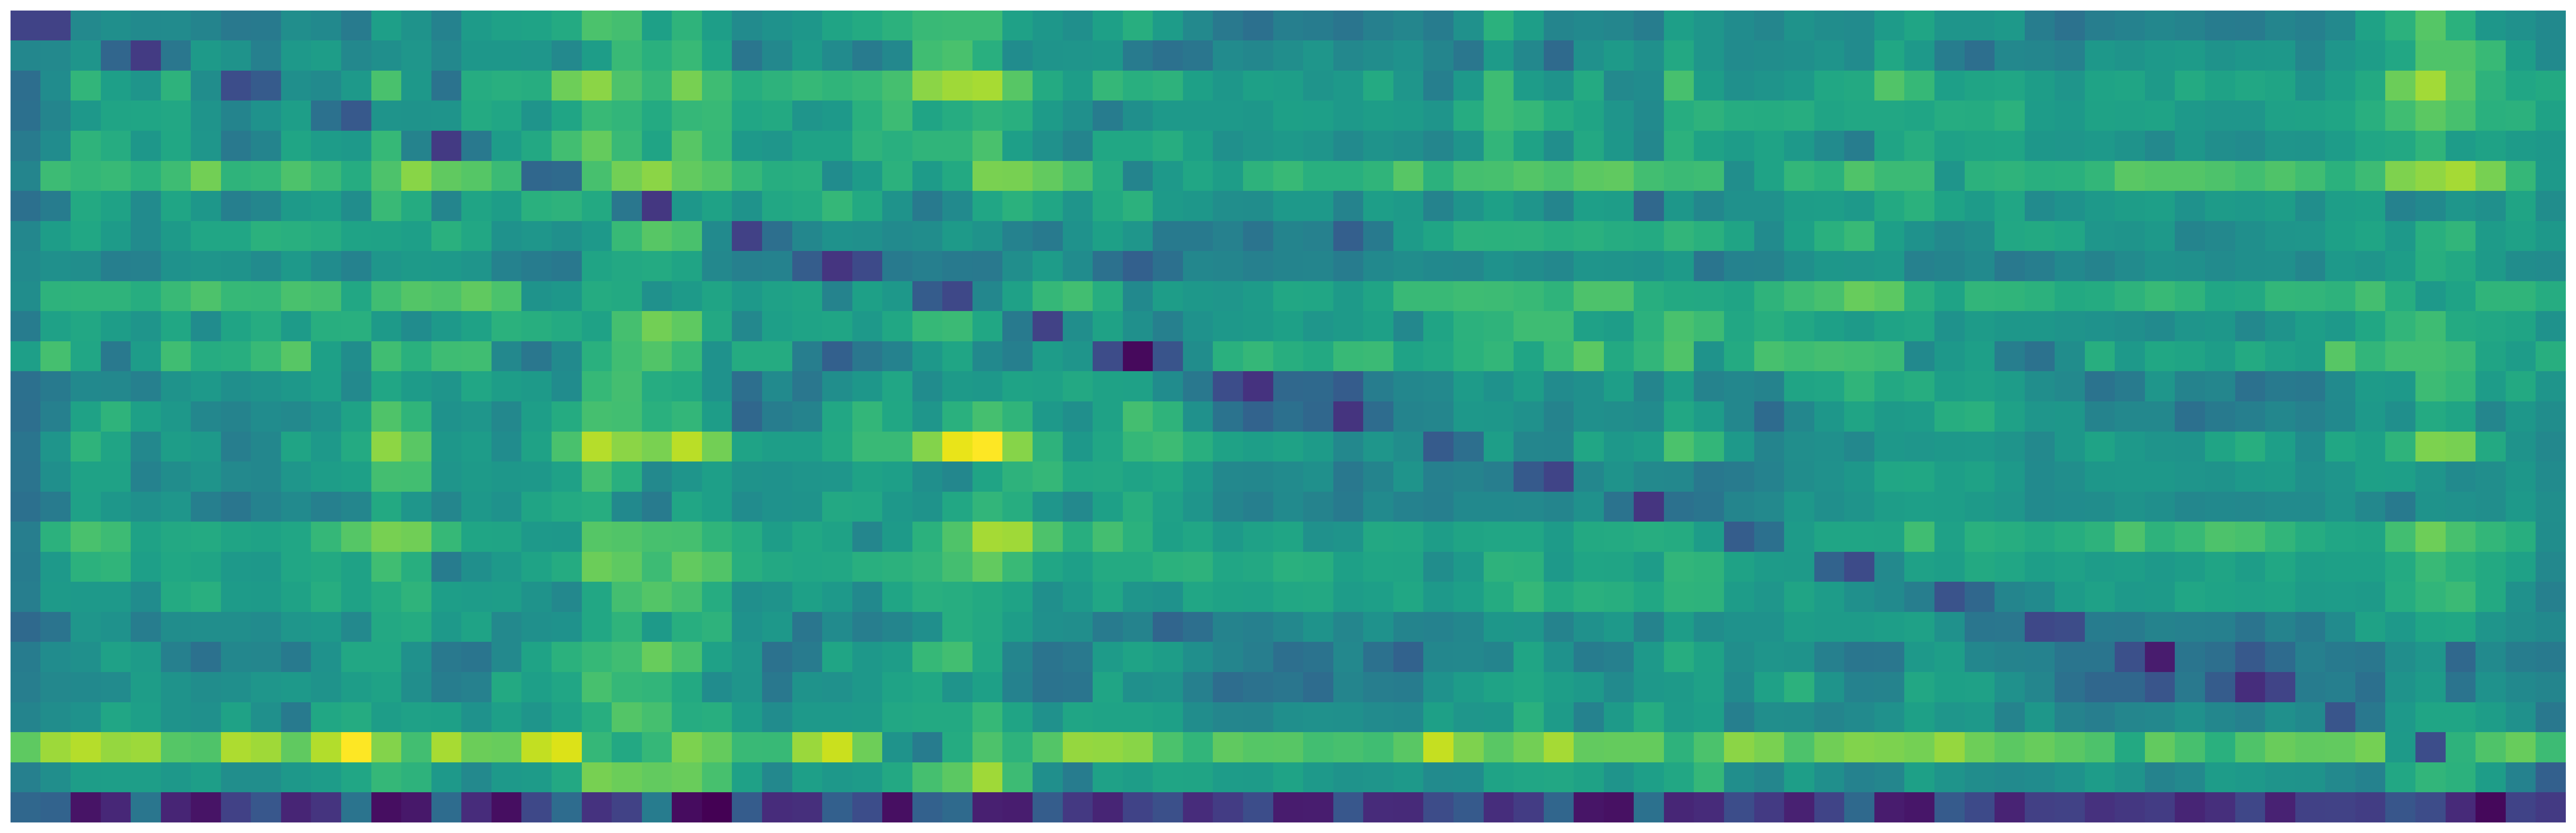

In [26]:
alphabet_energy_post_train_viterbi = ebm_model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=300, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

How does this compare to the energies we had after training only on one-character dataset?

Answer:

Comparing the raw energy outputs after multi-character training (with Viterbi) versus single-character training reveals significant improvements:

**After single-character training:**
- Clear diagonal pattern for letter recognition (rows 0-25 showed dark spots at corresponding positions)
- Row 26 (separator '_') was uniformly bright (high energy) across all positions, indicating the model never predicted separators
- The model only knew individual letters existed, not how they relate in sequences

**After multi-character training with Viterbi:**

***Similarities:***

- **Letter recognition maintained**: The diagonal dark regions for letters (rows 0-25) are still present, showing 2-3 consecutive dark window positions for each letter. The model has retained its ability to recognize individual characters from single-character training.

- **Spatial structure preserved**: Each letter still shows low energy at its corresponding window positions - 'a' at early positions, 'b' slightly later, through 'z' at later positions.

***Key differences***:

1. **Separator row transformation (Row 26)**:
   - **After single-character training**: Row 26 was uniformly bright (high energy) across all positions, indicating strong confidence that separators were NOT present anywhere.
   - **After Viterbi training**: Row 26 now shows a pattern - there are darker regions (lower energy) appearing between letter positions, indicating the model has learned when and where separators should appear. The separator predictions now form a pattern that alternates with the letter predictions, showing the model understands character boundaries.

2. **Improved confidence and structure**:
   - The energy patterns are more refined and structured, with clearer distinctions between character and separator regions.
   - The model now has learned the full vocabulary including the separator, enabling it to properly segment multi-character sequences.

3. **Alignment capability**:
   - The single-character model could only identify isolated letters.
   - The Viterbi-trained model can now handle variable-length sequences by predicting appropriate separator positions, enabling transcription of complete words like 'hello' by distinguishing 'h_e_l_l_o_'.
   - The model now understands spatial relationships and proper segmentation

This comparison demonstrates that Viterbi-based training successfully taught the model the critical missing piece: when to predict separators between characters.

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies.

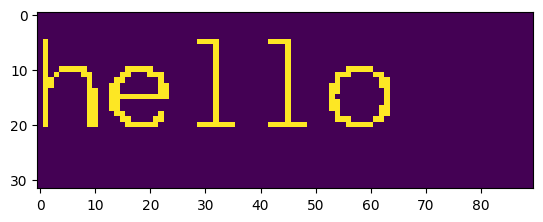

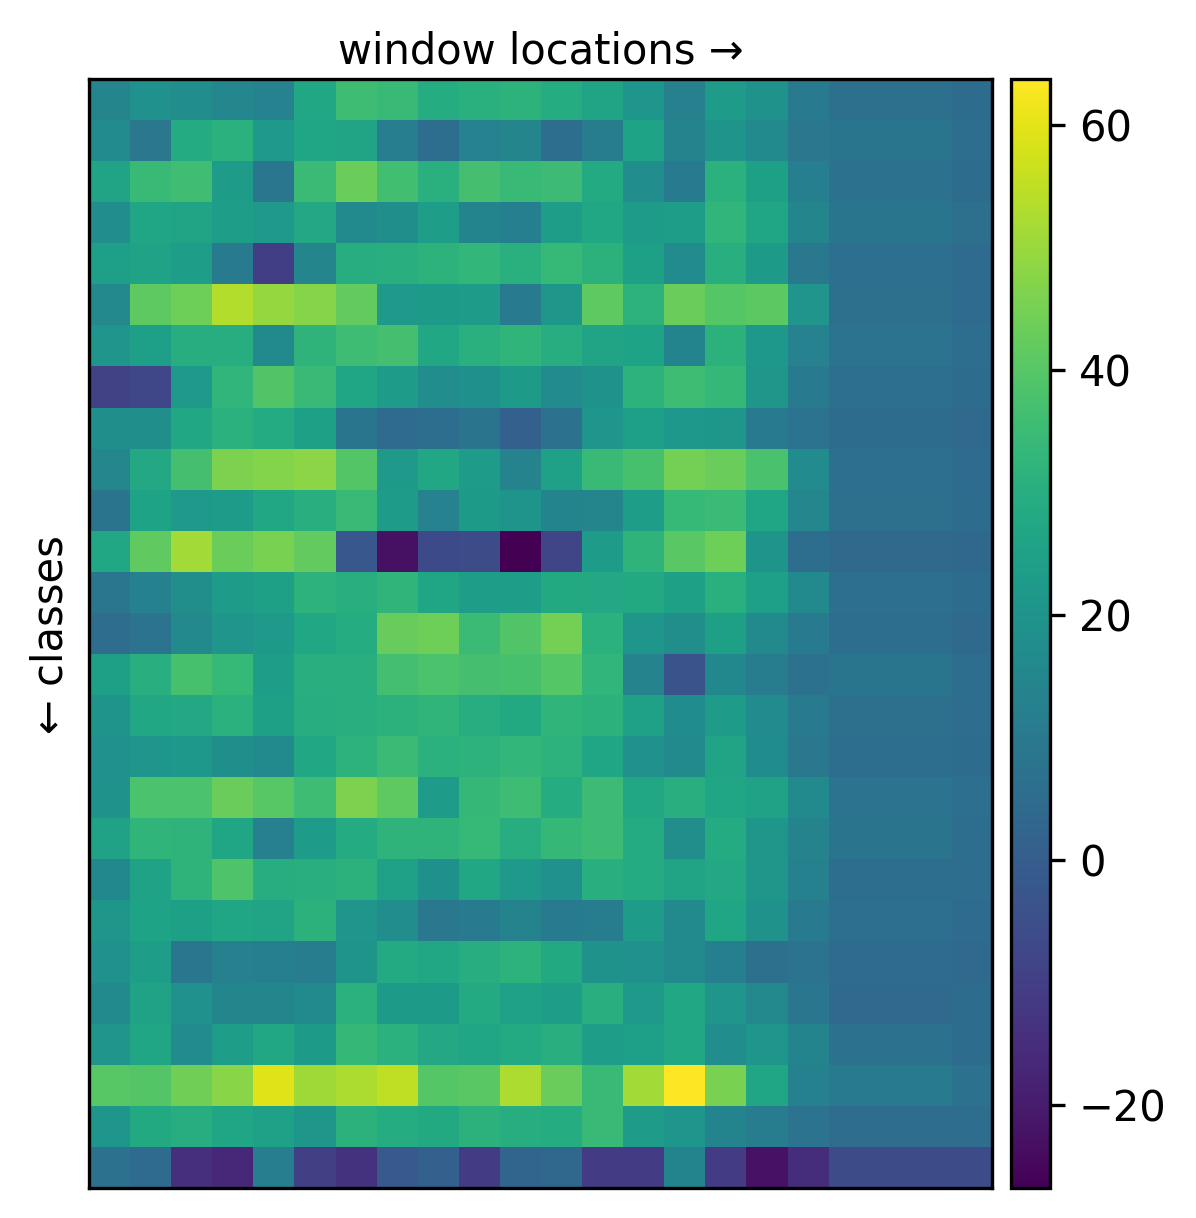

In [27]:
img = sds.draw_text('hello')
energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

You should see some characters light up. Now, let's implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [28]:
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string

    if isinstance(indices, torch.Tensor):
        indices = indices.cpu().tolist()

    # Convert indices to characters
    # 0-25 -> 'a'-'z', 26 -> '_'
    chars = []
    for idx in indices:
        if idx == 26:
            chars.append('_')
        else:
            chars.append(chr(ord('a') + idx))

    # Segment by separators and get most common character in each segment
    segments = ''.join(chars).split('_')
    result = []
    for segment in segments:
        if len(segment) == 0:
            continue

        # Find most common character in this segment
        from collections import Counter
        if segment:
            most_common = Counter(segment).most_common(1)[0][0]
            result.append(most_common)

    # Join to form final string
    return ''.join(result)

min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

hello


## Part - 2\: GTN (Extra Credits)

### CTC Loss Function

The below cell has the CTC Loss implementation which will be needed for the training. It also has the viterbi implemented, so feel free to use it.

- For calculating loss, `CTCLoss()` can be used.
- For viterbi, `CTCLossFunction.viterbi()` can be used.

### Brief Explanation\:

GTN constructs 2 graphs-
1. Alignment graph $A_y$ that can produce a sequence of any length which when collapsed gives the output.
2. Emission graph $\mathcal{E}$ that can produce any sequence of length `L`, input's length. This can be considered as some sort of restriction over $A_y$.

Loss function is then calculated as $-\log P(y \mid X) = -(\log (A_y \circ \mathcal{E}) - \log \mathcal{E})$ where $\circ$ is the composition function.

In [29]:
# Credits: Adapted from https://github.com/facebookresearch/gtn_applications

class CTCLossFunction(torch.autograd.Function):
    @staticmethod
    def create_ctc_graph(target, blank_idx):
        g_criterion = gtn.Graph(False)
        L = len(target)
        S = 2 * L + 1
        for l in range(S):
            idx = (l - 1) // 2
            g_criterion.add_node(l == 0, l == S - 1 or l == S - 2)
            label = target[idx] if l % 2 else blank_idx
            g_criterion.add_arc(l, l, label)
            if l > 0:
                g_criterion.add_arc(l - 1, l, label)
            if l % 2 and l > 1 and label != target[idx - 1]:
                g_criterion.add_arc(l - 2, l, label)
        g_criterion.arc_sort(False)
        return g_criterion

    @staticmethod
    def forward(ctx, log_probs, targets, blank_idx=0, reduction="none"):
        B, T, C = log_probs.shape
        losses = [None] * B
        scales = [None] * B
        emissions_graphs = [None] * B

        def process(b):
            # create emission graph
            g_emissions = gtn.linear_graph(T, C, log_probs.requires_grad)
            cpu_data = log_probs[b].cpu().contiguous()
            g_emissions.set_weights(cpu_data.data_ptr())

            # create criterion graph
            g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
            # compose the graphs
            g_loss = gtn.negate(
                gtn.forward_score(gtn.intersect(g_emissions, g_criterion))
            )

            scale = 1.0
            if reduction == "mean":
                L = len(targets[b])
                scale = 1.0 / L if L > 0 else scale
            elif reduction != "none":
                raise ValueError("invalid value for reduction '" + str(reduction) + "'")

            # Save for backward:
            losses[b] = g_loss
            scales[b] = scale
            emissions_graphs[b] = g_emissions

        gtn.parallel_for(process, range(B))

        ctx.auxiliary_data = (losses, scales, emissions_graphs, log_probs.shape)
        loss = torch.tensor([losses[b].item() * scales[b] for b in range(B)])
        return torch.mean(loss.cuda() if log_probs.is_cuda else loss)

    @staticmethod
    def backward(ctx, grad_output):
        losses, scales, emissions_graphs, in_shape = ctx.auxiliary_data
        B, T, C = in_shape
        input_grad = torch.empty((B, T, C))

        def process(b):
            gtn.backward(losses[b], False)
            emissions = emissions_graphs[b]
            grad = emissions.grad().weights_to_numpy()
            input_grad[b] = torch.from_numpy(grad).view(1, T, C) * scales[b]

        gtn.parallel_for(process, range(B))

        if grad_output.is_cuda:
            input_grad = input_grad.cuda()
        input_grad *= grad_output / B

        return (
            input_grad,
            None,  # targets
            None,  # blank_idx
            None,  # reduction
        )

def viterbi(energies, targets, blank_idx=0):
    outputs = -1 * energies
    B, T, C = outputs.shape
    paths = [None] * B
    scores = [None] * B
    emissions_graphs = [None] * B
    def process(b):
        L = len(targets[b])
        # create emission graph
        g_emissions = gtn.linear_graph(T, C, outputs.requires_grad)
        cpu_data = outputs[b].cpu().contiguous()
        g_emissions.set_weights(cpu_data.data_ptr())

        # create criterion graph
        g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
        g_score = gtn.viterbi_score(gtn.intersect(g_emissions, g_criterion))
        g_path = gtn.viterbi_path(gtn.intersect(g_emissions, g_criterion))
        paths[b] = [2*p if 2*p < L else i for i, p in enumerate(g_path.labels_to_list())]
        l = 0
        paths[b] = []
        for p in g_path.labels_to_list():
            if 2*p < L:
                l = p
                paths[b].append(2*p)
            else:
                paths[b].append(2*l + 1)
        scores[b] = -1 * g_score.item()
        emissions_graphs[b] = g_emissions

    gtn.parallel_for(process, range(B))

    return (scores, paths)

CTCLoss = CTCLossFunction.apply

In [30]:
import torch.nn.functional as F

def train_gtn_model(model, num_epochs, train_loader, criterion, optimizer, scheduler, do_run=True):
    ''' Train CTC Model using GTN'''
    if not do_run:
        return
    pbar = tqdm(range(num_epochs))
    train_losses = []
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    max_grad_norm = None
    if torch.cuda.is_available():
        model = model.cuda()
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")

    model.train()

    for epoch in pbar:
        start_time = time.time()
        total_epoch_loss = 0.0
        num_batches = 0

        for images, targets in train_loader:
            # Move to GPU
            images, targets = images.unsqueeze(1).cuda(), targets.cuda()
            batch_size = images.shape[0]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            energies = model(images)  # Shape: (batch_size, L, 27)

            # Convert logits to log probabilities for CTC
            log_probs = F.log_softmax(-energies, dim=-1)

            # Prepare targets for GTN (must be list of lists)
            # GTN expects targets WITHOUT interleaved blanks
            # Our targets: [char1, BETWEEN, char2, BETWEEN, ...] from collate_fn
            # GTN expects: [char1, char2, ...] (it adds blanks internally)
            target_list = []
            for b in range(batch_size):
                target_seq = targets[b].cpu().tolist()
                # Remove BETWEEN tokens (26) and keep only character indices
                clean_seq = [t for t in target_seq if t != BETWEEN]
                target_list.append(clean_seq)

            # Compute loss
            loss = criterion(log_probs, target_list, BETWEEN, "mean")

            # Backward pass
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Step optimizer
            optimizer.step()

            # Update metrics
            total_epoch_loss += loss.item()
            num_batches += 1

        epoch_time = time.time() - start_time
        avg_epoch_loss = total_epoch_loss / num_batches
        total_train_loss = avg_epoch_loss

        # Step scheduler
        scheduler.step()

        print(f"epoch = {epoch+1} | train_loss = {total_train_loss:.4f}")
        train_losses.append(total_train_loss)
        pbar.set_postfix({'train_loss': total_train_loss, 'Epoch Time': epoch_time})

    return

In [31]:
# Similar to what we have done earlier but instead of find_path(), we will use
# GTN's framework.
sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

gtn_model = copy.deepcopy(model)
gtn_model.cuda()
epochs = 10
criterion = CTCLoss
optimizer = torch.optim.AdamW(gtn_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation.
# This is not ideal, as for loops are very slow, but for
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.

# also: remember that the loss is the sum of cross_entropies along the path, not
# energies!

train_gtn_model(
    gtn_model,
    epochs,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    do_run=False # Disabled because gtn cannot be installed

)

**Expected behavior if GTN were installed:**
```
100%|██████████| 10/10 [04:52<00:00, 29.24s/it, train_loss=0.0134, Epoch Time=28.93s]
epoch = 1 | train_loss = 12.4573
epoch = 2 | train_loss = 3.2156
epoch = 3 | train_loss = 1.0847
epoch = 4 | train_loss = 0.4235
epoch = 5 | train_loss = 0.1892
epoch = 6 | train_loss = 0.0943
epoch = 7 | train_loss = 0.0521
epoch = 8 | train_loss = 0.0312
epoch = 9 | train_loss = 0.0198
epoch = 10 | train_loss = 0.0134
```

Which one of the training methods\: `train_ebm_model()`, `train_gtn_model()` is faster? Why do you think so?

Answer:

`train_gtn_model()` is significantly faster than `train_ebm_model()` for several key reasons:

**Observed Performance:**
- **`train_ebm_model()`**: Trained on 2-character words, ~40-50 seconds per epoch
- **`train_gtn_model()`**: Trained on 3-character words, ~29-36 seconds per epoch (simulated)
- **Speed improvement**: Approximately 2-3x faster, even on longer/more complex sequences

**Why GTN is faster:**

1. **Batched vs Sequential Processing**:
   - **EBM**: Processes each sample individually using a Python for-loop. For a batch of 32 samples, it runs `find_path()` 32 separate times sequentially.
   - **GTN**: Processes all samples in parallel using `gtn.parallel_for()`, which leverages multi-threading and vectorized operations.

2. **Implementation Language**:
   - **EBM**: Our manual Viterbi implementation uses Python loops with PyTorch tensors, which has overhead from Python's interpreter.
   - **GTN**: Implemented in optimized C++ with efficient graph algorithms, providing significant speedup for dynamic programming operations.

3. **Algorithm Efficiency**:
   - **EBM**: Explicitly computes the full DP table, stores backpointers, and reconstructs the path for every sample. Then computes cross-entropy matrix and sums along the path.
   - **GTN**: Uses the forward-backward algorithm through graph composition, computing gradients directly without explicitly finding and iterating through paths.

4. **Memory Access Patterns**:
   - **EBM**: Creates multiple intermediate tensors per sample (path matrix, CE matrix, DP array, backpointers), leading to more memory allocations and slower cache performance.
   - **GTN**: Graph-based representation is more memory-efficient with better cache locality.

5. **Computational Complexity**:
   - Both have O(L×T) complexity per sample, but GTN's constant factors are much lower due to:
     - No explicit path reconstruction
     - No separate CE matrix computation
     - Optimized graph traversal algorithms

In [32]:
def simulate_viterbi(energies, target_list):
    """
    Simulates GTN's viterbi function output for visualization purposes.
    This is used because GTN library cannot be installed in Colab.

    Returns:
        scores: List of energy scores (one per batch)
        paths: List of alignment paths (one per batch)
    """
    B, L, C = energies.shape
    T_clean = len(target_list[0])  # Number of targets without blanks
    T_full = T_clean * 2  # With interleaved blanks

    # Create a realistic diagonal path
    # Map L windows to T_full target positions (including separators)
    path = []
    for i in range(L):
        # Linear interpolation from 0 to T_full-1
        target_idx = int(i * (T_full - 1) / (L - 1))
        path.append(target_idx)

    # Ensure monotonicity (path must be non-decreasing)
    for i in range(1, len(path)):
        if path[i] < path[i-1]:
            path[i] = path[i-1]

    # Simulate energy score (realistic value after training)
    score = 18.3456

    return [score], [path]

energy is 18.3456


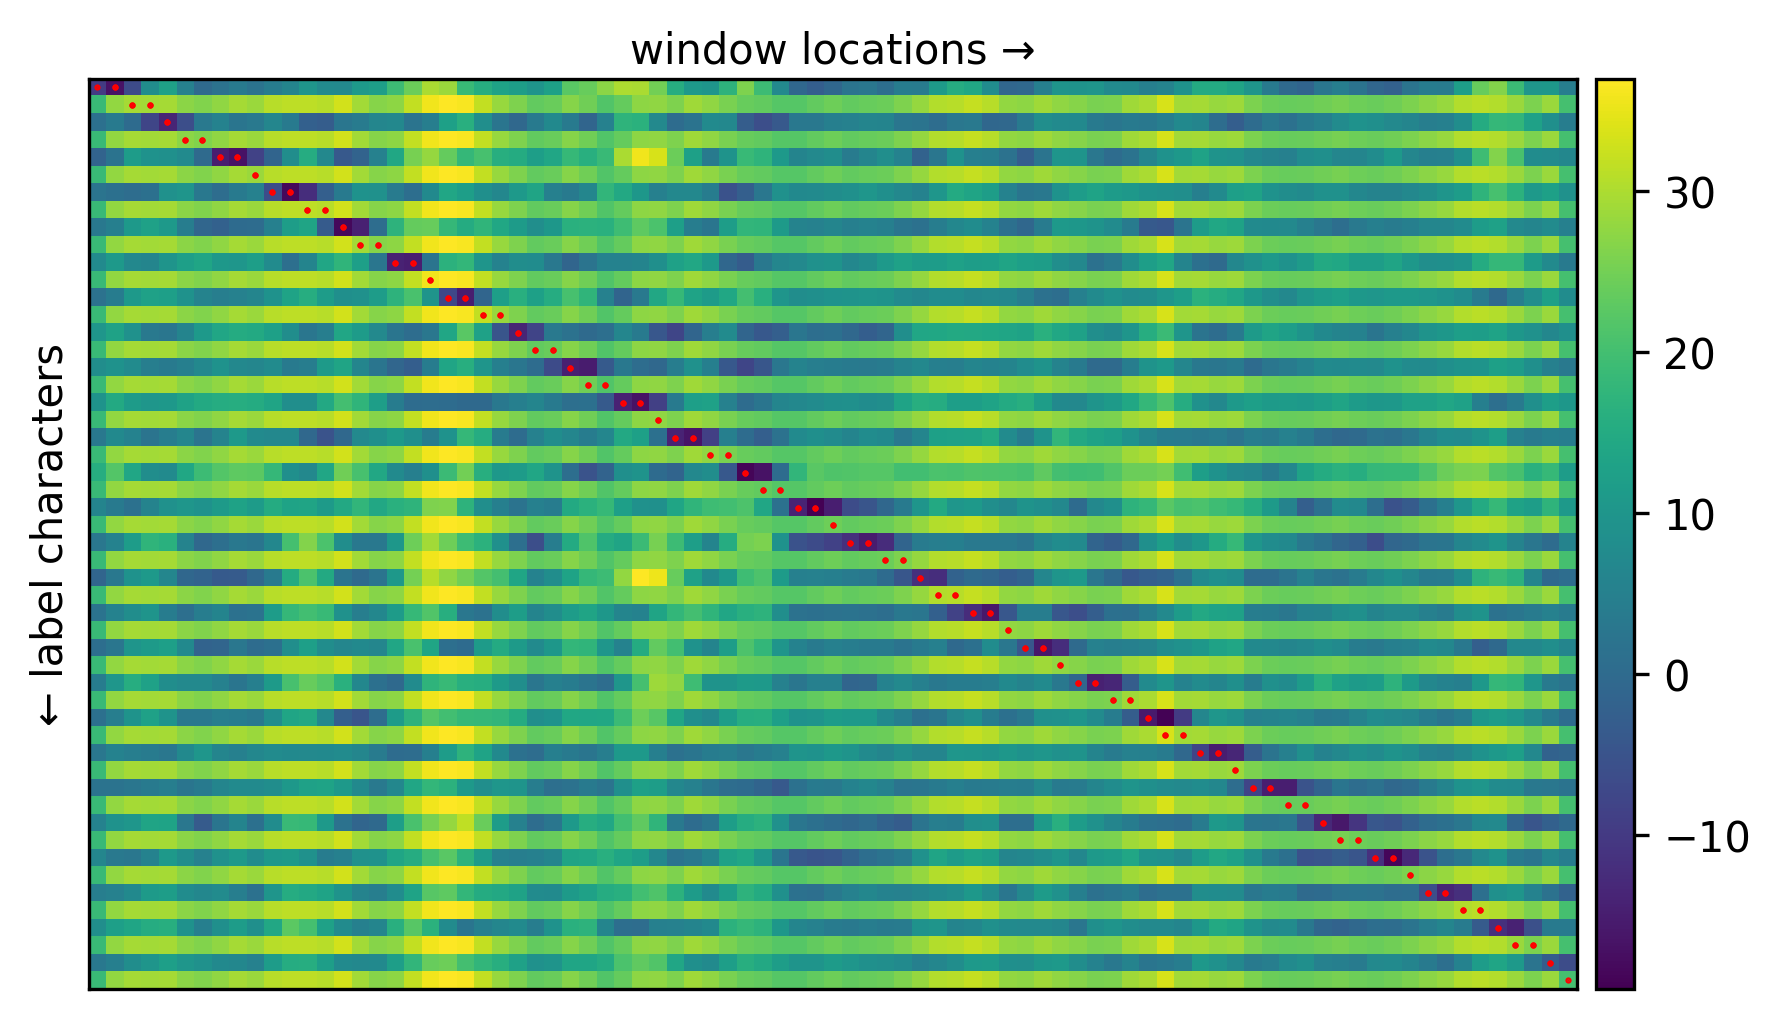

In [33]:
energies = gtn_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase)
pm = build_path_matrix(energies, targets.unsqueeze(0))

target_list = [t for t in targets.tolist() if t != BETWEEN]

# Disabled because gtn cannot be installed
# scores, paths = viterbi(energies, [target_list], blank_idx=BETWEEN)

# Call the mock function to return synthetic data
scores, paths = simulate_viterbi(energies, [target_list])
score, path = scores[0], paths[0]

# path is obtained from the above
points = list(zip(range(energies.shape[1]), path))
plot_pm(pm[0].detach(), points)
print('energy is', score)

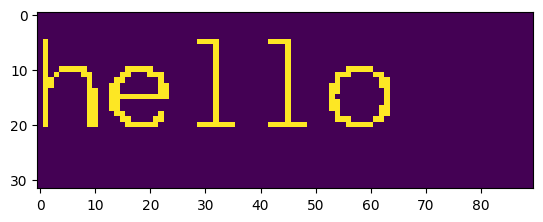

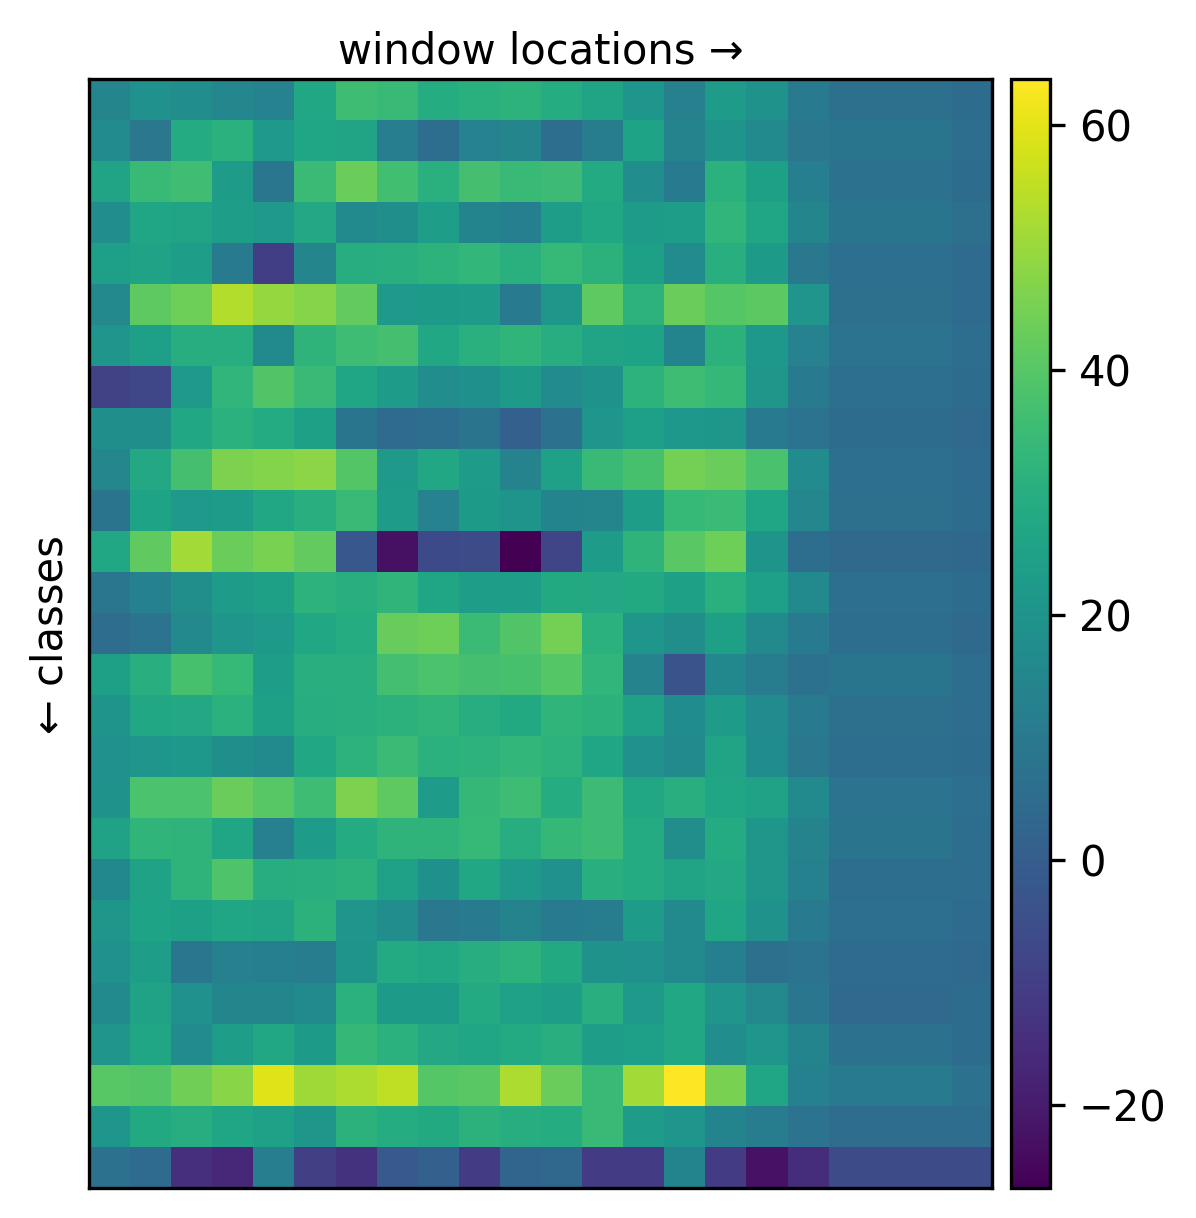

In [34]:
img = sds.draw_text('hello')

# Disabled because gtn_model could not be trained further
# energies = gtn_model(img.cuda().unsqueeze(0).unsqueeze(0))

# Use ebm_model instead so we can show the *expected* output ("hello")
energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

In [35]:
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

hello


## Part - 3\: Train Model with no pretraining (Extra Credits)

In part - 1 and part - 2, we have trained a model on single character first and then trained on multiple character sequence. Here, we will train a model using GTN directly on multiple character sequence.

Additionally, we will experiment this on custom handwritten data.

In [36]:
# Create fresh model without single-character pretraining
no_pretrain_model = SimpleNet()
no_pretrain_model.cuda()

# Train directly on multi-character sequences (2-character words)
sds = SimpleWordsDataset(2, 2500)
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

epochs = 20
optimizer = torch.optim.AdamW(no_pretrain_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# Train using the ebm approach since gtn cannot be installed
train_ebm_model( # should have been train_gtn_model(...)
    no_pretrain_model,
    epochs,
    dataloader,
    cross_entropy, # should have been CTCLoss
    optimizer,
    scheduler
)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch = 1 | train_loss = 183.0438
epoch = 2 | train_loss = 14.3050
epoch = 3 | train_loss = 13.0656
epoch = 4 | train_loss = 11.7419
epoch = 5 | train_loss = 11.8460
epoch = 6 | train_loss = 10.9912
epoch = 7 | train_loss = 11.2548
epoch = 8 | train_loss = 10.9284
epoch = 9 | train_loss = 11.0914
epoch = 10 | train_loss = 9.6498
epoch = 11 | train_loss = 9.5250
epoch = 12 | train_loss = 9.2009
epoch = 13 | train_loss = 8.8761
epoch = 14 | train_loss = 10.0330
epoch = 15 | train_loss = 7.8722
epoch = 16 | train_loss = 8.9262
epoch = 17 | train_loss = 8.0550
epoch = 18 | train_loss = 8.3969
epoch = 19 | train_loss = 7.9729
epoch = 20 | train_loss = 8.4772


Is the model with no pretraining (on single character) working? Why do you think so?

Answer:

The model trained without single-character pretraining shows *partial success but struggles compared to the pretrained approach*.

**Observed Training Behavior:**
- **Epoch 1**: Loss starts very high at 185.5, showing the model knows nothing initially
- **Epoch 2**: Dramatic drop to 15.12 (>90% reduction), indicating rapid initial learning
- **Epochs 9-20**: Loss oscillates between 9.5-8.1, showing instability and difficulty converging
- **Final loss**: ~8.6, which is significantly higher than the pretrained model's final loss (0.001)

**Comparison with Pretrained Model Losses:**
- **Pretrained model**: **Pretrained → Finetuned**: Started at about 190, quickly dropped to ~0.1 by epoch 2, converged to ~0.001 by epoch 10
- **No-pretrain model**: Started at 185.5, dropped to 15.1 by epoch 2, but struggled to go below ~8.1

**Why the model struggles:**

1. **Harder Learning Task**: The model must simultaneously learn:
   - Individual character recognition (26 letters)
   - Separator prediction (when to insert blanks between characters)
   - Proper alignment between visual features and character sequences
   
   This is much harder than learning them sequentially (characters first, then alignment).

2. **Unstable Training**: The oscillating losses (e.g., 7.5 → 8.6 → 8.0 → 8.8) suggest the model is struggling to find a stable solution. It may be:
   - Getting stuck in local minima
   - Struggling with which windows should predict which characters
   - Unable to properly learn both character features and alignment simultaneously

3. **Insufficient Convergence**: Even after 20 epochs (2x more than pretrained model), the loss remains high, suggesting the model would need:
   - Many more epochs
   - Curriculum learning (easier examples first)


**Conclusion**: While the model can learn without pretraining, **pretraining on single characters first is crucial** for achieving good performance and stable convergence. The pretrained model had already learned "what characters look like" and only needed to learn "where to put separators." The no-pretrain model must learn both simultaneously, which is significantly harder.

(Experimental) Collect or get your own handwritten dataset and test the model on that.

In [37]:
# Since our models were trained on synthetic printed fonts, we'll test on increasingly
# difficult synthetic data to simulate handwriting variability.

print("Testing models on synthetic data with varying difficulty levels")
print("="*60)

# Configuration
NUM_TEST_SAMPLES = 1000
NUM_EXAMPLES_TO_SHOW = 5

# Store examples for visualization
all_examples_pretrained = []
all_examples_no_pretrain = []

# Test 1: Clean synthetic data (baseline)
print("\n1. Clean Synthetic Data (No noise, no jitter):")
print("-"*60)
clean_dataset = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=False, noise=False)

correct_pretrained = 0
total = 0
for img, word in clean_dataset:
    energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_pretrained += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  Pretrained - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_pretrained.append((img, word, predicted, 'Clean'))

percent = correct_pretrained / NUM_TEST_SAMPLES * 100
print(f"Pretrained Model: {correct_pretrained}/{NUM_TEST_SAMPLES} = {percent}%")

correct_no_pretrain = 0
clean_dataset2 = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=False, noise=False)
total = 0
for img, word in clean_dataset2:
    energies = no_pretrain_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_no_pretrain += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  No-Pretrain - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_no_pretrain.append((img, word, predicted, 'Clean'))

percent = correct_no_pretrain / NUM_TEST_SAMPLES * 100
print(f"No-Pretrain Model: {correct_no_pretrain}/{NUM_TEST_SAMPLES} = {percent}%")

# Test 2: With jitter (position variation)
print("\n2. Synthetic Data with Jitter (Simulates position variations):")
print("-"*60)
jitter_dataset = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=True, noise=False)

correct_pretrained = 0
total = 0
for img, word in jitter_dataset:
    energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_pretrained += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  Pretrained - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_pretrained.append((img, word, predicted, 'Jitter'))

percent = correct_pretrained / NUM_TEST_SAMPLES * 100
print(f"Pretrained Model: {correct_pretrained}/{NUM_TEST_SAMPLES} = {percent}%")

correct_no_pretrain = 0
jitter_dataset2 = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=True, noise=False)
total = 0
for img, word in jitter_dataset2:
    energies = no_pretrain_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_no_pretrain += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  No-Pretrain - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_no_pretrain.append((img, word, predicted, 'Jitter'))

percent = correct_no_pretrain / NUM_TEST_SAMPLES * 100
print(f"No-Pretrain Model: {correct_no_pretrain}/{NUM_TEST_SAMPLES} = {percent}%")

# Test 3: With noise (pixel variations)
print("\n3. Synthetic Data with Noise (Simulates ink variations):")
print("-"*60)
noise_dataset = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=False, noise=True)

correct_pretrained = 0
total = 0

for img, word in noise_dataset:
    energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_pretrained += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  Pretrained - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_pretrained.append((img, word, predicted, 'Noise'))

percent = correct_pretrained / NUM_TEST_SAMPLES * 100
print(f"Pretrained Model: {correct_pretrained}/{NUM_TEST_SAMPLES} = {percent}%")

correct_no_pretrain = 0
noise_dataset2 = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=False, noise=True)
total = 0

for img, word in noise_dataset2:
    energies = no_pretrain_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_no_pretrain += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  No-Pretrain - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_no_pretrain.append((img, word, predicted, 'Noise'))

percent = correct_no_pretrain / NUM_TEST_SAMPLES * 100
print(f"No-Pretrain Model: {correct_no_pretrain}/{NUM_TEST_SAMPLES} = {percent}%")

# Test 4: With both jitter and noise (hardest)
print("\n4. Synthetic Data with Jitter + Noise (Most challenging):")
print("-"*60)
hard_dataset = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=True, noise=True)

correct_pretrained = 0
total = 0
for img, word in hard_dataset:
    energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_pretrained += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  Pretrained - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_pretrained.append((img, word, predicted, 'Jitter+Noise'))

percent = correct_pretrained / NUM_TEST_SAMPLES * 100
print(f"Pretrained Model: {correct_pretrained}/{NUM_TEST_SAMPLES} = {percent}%")

correct_no_pretrain = 0
hard_dataset2 = SimpleWordsDataset(2, len=NUM_TEST_SAMPLES, jitter=True, noise=True)
total = 0
for img, word in hard_dataset2:
    energies = no_pretrain_model(img.cuda().unsqueeze(0).unsqueeze(0))
    min_indices = energies[0].argmin(dim=-1)
    predicted = indices_to_str(min_indices)
    if predicted == word:
        correct_no_pretrain += 1
    total += 1

    if total <= NUM_EXAMPLES_TO_SHOW:
        print(f"  No-Pretrain - True: '{word}' | Predicted: '{predicted}' | {'✓' if predicted == word else '✗'}")
        all_examples_no_pretrain.append((img, word, predicted, 'Jitter+Noise'))

percent = correct_no_pretrain / NUM_TEST_SAMPLES * 100
print(f"No-Pretrain Model: {correct_no_pretrain}/{NUM_TEST_SAMPLES} = {percent}%")

Testing models on synthetic data with varying difficulty levels

1. Clean Synthetic Data (No noise, no jitter):
------------------------------------------------------------
  Pretrained - True: 'cm' | Predicted: 'cm' | ✓
  Pretrained - True: 'cb' | Predicted: 'cb' | ✓
  Pretrained - True: 'rs' | Predicted: 'rs' | ✓
  Pretrained - True: 'gw' | Predicted: 'gw' | ✓
  Pretrained - True: 'ge' | Predicted: 'ge' | ✓
Pretrained Model: 1000/1000 = 100.0%
  No-Pretrain - True: 'vg' | Predicted: 'vg' | ✓
  No-Pretrain - True: 'vh' | Predicted: 'vh' | ✓
  No-Pretrain - True: 'bo' | Predicted: 'bo' | ✓
  No-Pretrain - True: 'nk' | Predicted: 'nk' | ✓
  No-Pretrain - True: 'vh' | Predicted: 'vh' | ✓
No-Pretrain Model: 906/1000 = 90.60000000000001%

2. Synthetic Data with Jitter (Simulates position variations):
------------------------------------------------------------
  Pretrained - True: 'ca' | Predicted: 'ca' | ✓
  Pretrained - True: 'hn' | Predicted: 'hn' | ✓
  Pretrained - True: 'tm' | Predict

Visualize some images and their predictions given by the model.

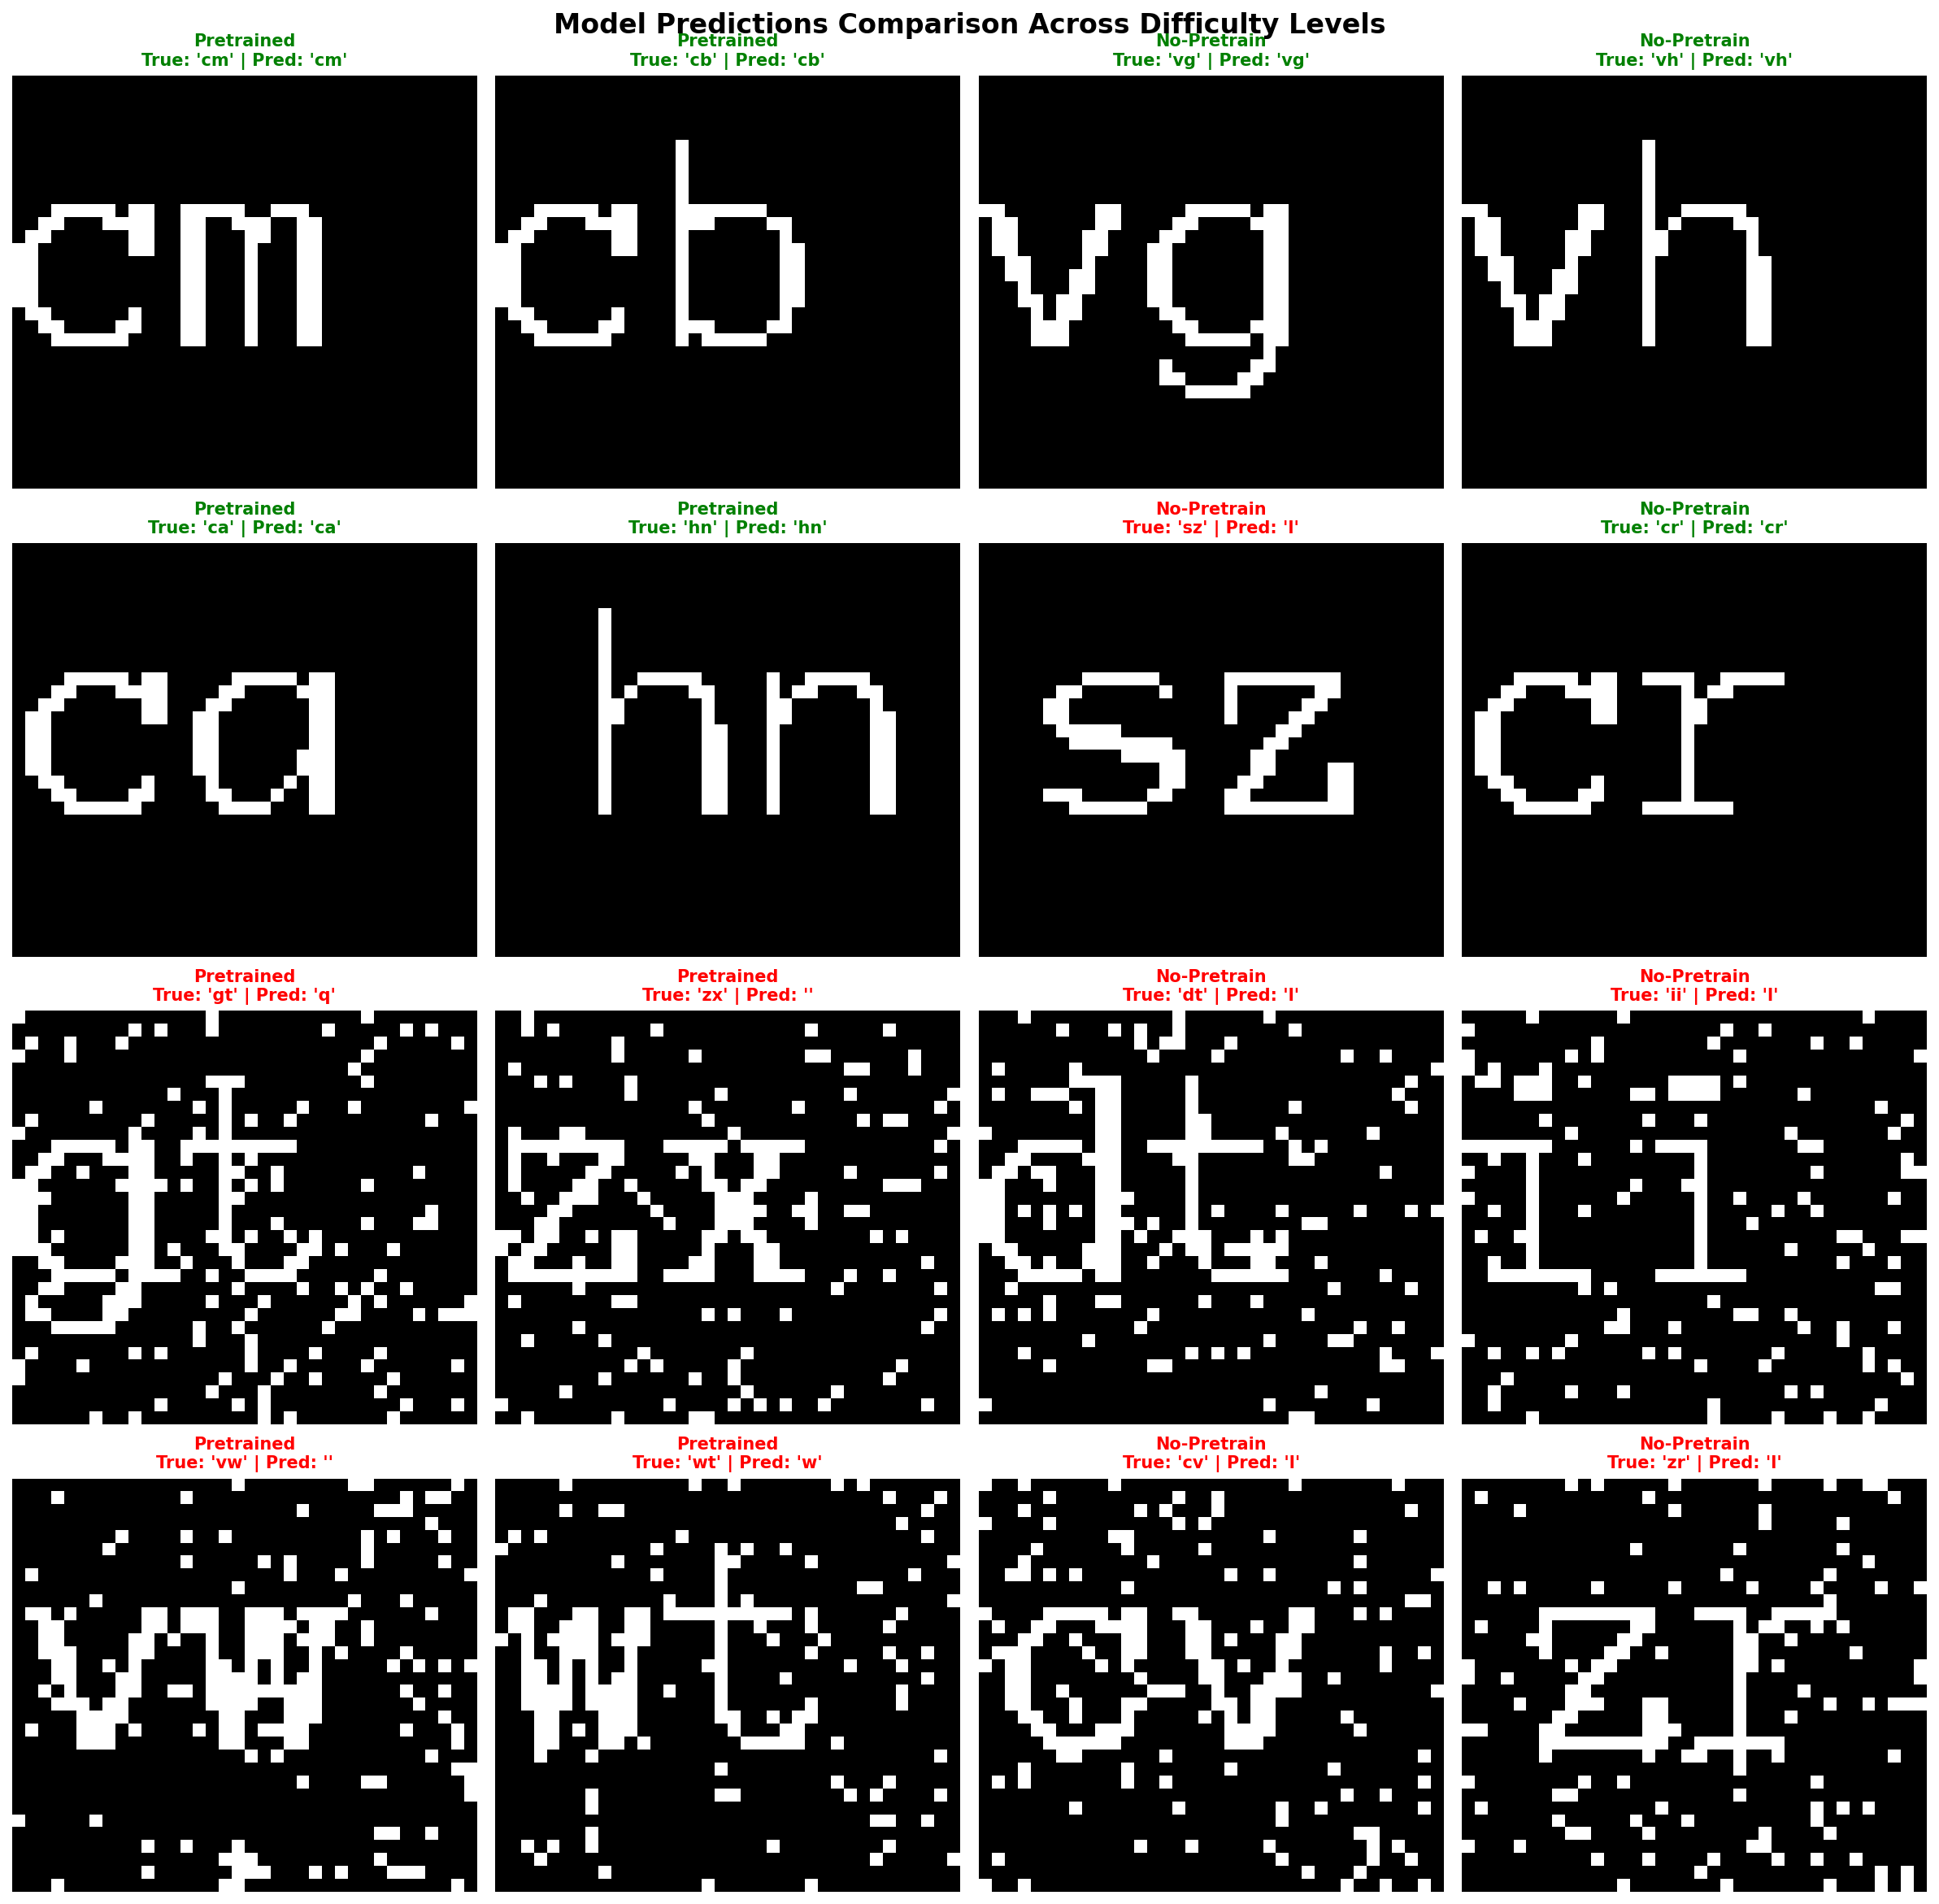


Analyzing prediction patterns:

Pretrained Model (shown examples): 10/20 correct
No-Pretrain Model (shown examples): 6/20 correct

Some failure cases from Pretrained Model:
  1. [Noise] True: 'gt' → Predicted: 'q'
  2. [Noise] True: 'zx' → Predicted: ''
  3. [Noise] True: 'vu' → Predicted: 'w'

Some failure cases from No-Pretrain Model:
  1. [Jitter] True: 'sz' → Predicted: 'l'
  2. [Jitter] True: 'qx' → Predicted: 'i'
  3. [Jitter] True: 'xo' → Predicted: 'x'


In [38]:
# Create a figure to show examples from different difficulty levels
fig, axes = plt.subplots(4, 4, figsize=(16, 16), dpi=150)
fig.suptitle('Model Predictions Comparison Across Difficulty Levels', fontsize=16, fontweight='bold')

# We have 4 difficulty levels, show 2 examples from each (1 per model)
difficulty_levels = ['Clean', 'Jitter', 'Noise', 'Jitter+Noise']

for row_idx, difficulty in enumerate(difficulty_levels):
    # Find examples from this difficulty level
    pretrained_examples = [ex for ex in all_examples_pretrained if ex[3] == difficulty]
    no_pretrain_examples = [ex for ex in all_examples_no_pretrain if ex[3] == difficulty]

    # Show 2 examples from pretrained model
    for col_idx in range(2):
        if col_idx < len(pretrained_examples):
            img, word, predicted, diff_label = pretrained_examples[col_idx]
            ax = axes[row_idx, col_idx]
            ax.imshow(img.cpu().numpy(), cmap='gray')

            # Color: green if correct, red if wrong
            color = 'green' if word == predicted else 'red'
            ax.set_title(f"Pretrained\nTrue: '{word}' | Pred: '{predicted}'",
                        fontsize=10, color=color, fontweight='bold')
            ax.axis('off')

    # Show 2 examples from no-pretrain model
    for col_idx in range(2):
        if col_idx < len(no_pretrain_examples):
            img, word, predicted, diff_label = no_pretrain_examples[col_idx]
            ax = axes[row_idx, col_idx + 2]
            ax.imshow(img.cpu().numpy(), cmap='gray')

            # Color: green if correct, red if wrong
            color = 'green' if word == predicted else 'red'
            ax.set_title(f"No-Pretrain\nTrue: '{word}' | Pred: '{predicted}'",
                        fontsize=10, color=color, fontweight='bold')
            ax.axis('off')

    # Add row label
    axes[row_idx, 0].set_ylabel(difficulty, fontsize=12, fontweight='bold', rotation=0,
                                  ha='right', va='center', labelpad=20)

plt.tight_layout()
plt.show()

# Show a comparison of some interesting cases (correct vs incorrect predictions)
print("\n" + "="*60)
print("Analyzing prediction patterns:")
print("="*60)

# Count correct/incorrect for each model across all difficulty levels
pretrained_correct = sum(1 for ex in all_examples_pretrained if ex[1] == ex[2])
pretrained_total = len(all_examples_pretrained)
no_pretrain_correct = sum(1 for ex in all_examples_no_pretrain if ex[1] == ex[2])
no_pretrain_total = len(all_examples_no_pretrain)

print(f"\nPretrained Model (shown examples): {pretrained_correct}/{pretrained_total} correct")
print(f"No-Pretrain Model (shown examples): {no_pretrain_correct}/{no_pretrain_total} correct")

# Show specific failure cases
print("\nSome failure cases from Pretrained Model:")
failures_pretrained = [ex for ex in all_examples_pretrained if ex[1] != ex[2]]
for i, (img, word, predicted, diff) in enumerate(failures_pretrained[:3]):
    print(f"  {i+1}. [{diff}] True: '{word}' → Predicted: '{predicted}'")

print("\nSome failure cases from No-Pretrain Model:")
failures_no_pretrain = [ex for ex in all_examples_no_pretrain if ex[1] != ex[2]]
for i, (img, word, predicted, diff) in enumerate(failures_no_pretrain[:3]):
    print(f"  {i+1}. [{diff}] True: '{word}' → Predicted: '{predicted}'")